# **Análisis de características influyentes en los precios de alojamientos de Airbnb en la ciudad de Washington D.C usando modelos de regresión.** <br>

Este trabajo se enfocará en hacer un análisis de las características que influyen en el precio de los alojamientos de Airbnb en la ciudad de Washington D.C en Estados Unidos usando modelos de regresión en Python.

El desarrollo estará conformado de la siguiente forma:
- Ciudad de caso de estudio
- Análisis de los datos
- Preprocesado y limpieza de los datos 
- Transformación de los datos
- Selección de características 
- Modelos de regresión    
- Análisis y visualización de los resultados

# **Carga de librerias**

In [1]:
# https://pysal.org/libpysal/tutorial.html
#import libpysal as lps

# Importar Módulos a utilizar
import io
from io import BytesIO
import gzip
import timeit

# Librerías para gráficar
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
import dexplot as dxp

# Librerías para obtener datos
import requests
from urllib.request import Request, urlopen

# Librerías para manejo de datos
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Librerías para normalización de datos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Librerías para datos espaciales
import geopandas as gpd
from pyproj import Geod
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import shapely.wkt
import shapely.geometry

# Librerías para mapas interactivos, Mediante Folium podemos manipular los datos en Python y visualizar los resultados en Leaflet.
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

# Librerías para regresión cuantílica
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.regression.quantile_regression import QuantReg

# Configuración para mostrar la salida sin que se recorten los datos
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 500
pd.options.display.width = 4000

# Configuración para no mostrar warnings
import warnings
warnings.filterwarnings("ignore")

# Configuración para gráficas
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [8, 8]

# **Carga de datos**

Obtener datos de los diferentes alojamientos que posee Airbnb en la ciudad de Washington D.C, en este caso los datos provienen de la página Inside Airbnb. <br>
http://insideairbnb.com/washington-dc

In [2]:
# obtenemos los datos desde la fuente
url_inside_airbnb = "http://data.insideairbnb.com/united-states/dc/washington-dc/2022-09-14/data/listings.csv.gz"
req = Request(url_inside_airbnb)
req.add_header('Accept-Encoding', 'gzip')
response = urlopen(req)

# los datos vienen en formato gzip, por lo tanto hay que descomprimir el archivo y cargar los datos a un dataframe de pandas
content = gzip.decompress(response.read())
alojamientos = pd.read_csv(io.StringIO(content.decode('utf-8')))

# creamos una estructura de geopandas para datos espaciales, con una columna geometry que contiene las coordenadas 
# coordinate reference system (CRS)
alojamientos_gdf = gpd.GeoDataFrame(alojamientos, geometry=gpd.points_from_xy(alojamientos.longitude, alojamientos.latitude), crs='EPSG:4326')

Se obtienen los datos geográficos de los barrios de la ciudad de Washington DC. <br>
http://insideairbnb.com/get-the-data/

In [3]:
# obtenemos los datos desde la fuente
url_vecindarios_airbnb = "http://data.insideairbnb.com/united-states/dc/washington-dc/2022-09-14/visualisations/neighbourhoods.geojson"
vecindarios_airbnb = gpd.read_file(url_vecindarios_airbnb)

Se obtienen los datos de incidentes de crimenes en el 2020 en la ciudad de Washington DC. <br>
https://opendata.dc.gov/datasets/crime-incidents-in-2020/explore?location=38.913236%2C-77.030441%2C16.00

In [4]:
# obtenemos los datos desde la fuente
url_crime_incidents = "https://opendata.arcgis.com/api/v3/datasets/f516e0dd7b614b088ad781b0c4002331_2/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
crime_incidents = gpd.read_file(url_crime_incidents)

Se obtienen los principales puntos de interés de la ciudad de Washington DC. <br>
https://opendata.dc.gov/datasets/points-of-interest/explore?location=38.890773%2C-77.033733%2C13.83 <br>

Aqui se encuentra información de sitios históricos, nombres de edificaciones, estationes de metro, circulos de tráfico, edificios federales, sitios culturales y embajadas.

In [5]:
# obtenemos los datos desde la fuente
url_point_of_interest = "https://opendata.arcgis.com/api/v3/datasets/f323f677b3f34fe08956b8fcce3ace44_3/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
point_of_interest = gpd.read_file(url_point_of_interest)

De los puntos de interés se trabajará puntualmente con algunos de los más conocidos como:
- La casa blanca
- Monumento a Lincoln
- Monumento a Washington
- Museo Nacional del Aire y el Espacio de Estados Unidos
- Zoologico Nacional

<br>
Estos sitios tendrán su propia columna en el dataset.

In [6]:
CASA_BLANCA = point_of_interest[ point_of_interest["ALIASNAME"] == "WHITE HOUSE" ]
LINCOLN_MEMORIAL = point_of_interest[ point_of_interest["ALIASNAME"] == "LINCOLN MEMORIAL" ]
WASHINGTON_MONUMENT = point_of_interest[ point_of_interest["ALIASNAME"] == "WASHINGTON MONUMENT" ]
NATIONAL_AIR_AND_SPACE_MUSEUM = point_of_interest[ point_of_interest["ALIASNAME"] == "NATIONAL AIR AND SPACE MUSEUM" ]
NATIONAL_ZOOLOGICAL_PARK = point_of_interest[ point_of_interest["ALIASNAME"] == "NATIONAL ZOO ADMINISTRATION" ]

Se obtienen datos geográficos de los sitios para recreación.
<br>
https://opendata.dc.gov/datasets/DCGIS::recreation-facilities-1/explore

In [7]:
# obtenemos los datos desde la fuente
url_recreation_facilities = "https://opendata.arcgis.com/api/v3/datasets/7122c1c815314588abe5c1864da8a355_3/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
recreation_facilities = gpd.read_file(url_recreation_facilities)

Se obtienen datos geográficos de localización de bancos. <br>
https://opendata.dc.gov/maps/bank-locations

In [8]:
# obtenemos los datos desde la fuente
url_bank_location = "https://opendata.arcgis.com/api/v3/datasets/dfc51a5bd29347d0a2399743d3144d31_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
bank_location = gpd.read_file(url_bank_location)

Se obtienen datos geográficos de paradas de bus del metro.
<br>
https://opendata.dc.gov/datasets/metro-bus-stops-2/explore?location=38.892509%2C-77.020630%2C12.69

In [9]:
# obtenemos los datos desde la fuente
#url_metro_lines ="https://opendata.arcgis.com/api/v3/datasets/a29b9dbb2f00459db2b0c3c56faca297_106/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
url_metro_bus_stop = "https://opendata.arcgis.com/api/v3/datasets/a29b9dbb2f00459db2b0c3c56faca297_53/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
metro_bus_stop = gpd.read_file(url_metro_bus_stop)

# **Preprocesado y limpieza de datos**

Revisión del dataset

In [10]:
alojamientos_gdf.head()

id                          listing_url       scrape_id last_scraped       source                                             name                                        description                              neighborhood_overview                                        picture_url  host_id                                   host_url host_name  host_since   host_location                                         host_about  host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url host_neighbourhood  host_listings_count  host_total_listings_count                host_verifications host_has_profile_pic host_identity_verified                                    neighbourhood                             neighbourhood_cleansed  neighbourhood_group_cleansed   latitude  longitude                property_type        room_type  accommodates  bathrooms  bathrooms_text  bedrooms  beds                                          amenities    price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated has_availability  availability_30  availability_60  availability_90  availability_365 calendar_last_scraped  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d first_review last_review  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value                           license instant_bookable  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month                    geometry
0    3686    https://www.airbnb.com/rooms/3686  20220914194735   2022-09-14  city scrape                                  Vita's Hideaway  IMPORTANT NOTES<br />* Carefully read and be s...  We love that our neighborhood is up and coming...  https://a0.muscache.com/pictures/61e02c7e-3d66...     4645     https://www.airbnb.com/users/show/4645      Vita  2008-11-26  Washington, DC  I am a literary scholar, teacher, poet, vegan ...        within a day               100%                 100%                 f  https://a0.muscache.com/im/users/4645/profile_...  https://a0.muscache.com/im/users/4645/profile_...          Anacostia                  1.0                        4.0  ['email', 'phone', 'work_email']                    t                      t  Washington, District of Columbia, United States                                 Historic Anacostia                           NaN  38.863390 -76.988890         Private room in home     Private room             1        NaN  1 private bath       1.0   1.0  ["Dryer", "Smoke alarm", "Cooking basics", "In...   $67.00              31             365                    31.0                    31.0                   365.0                   365.0                    31.0                   365.0               NaN                t                0                1               31               306            2022-09-14                 81                      5                       0   2010-11-01  2022-07-06                  4.63                    4.72                       4.43                   4.90                         4.83                    3.86                 4.62                               NaN                f                               1                                            0                                             1                                            0               0.56  POINT (-76.98889 38.86339)
1  841260  https://www.airbnb.com/rooms/841260  20220914194735   2022-09-15  city scrape              Metro Style Living in Washington DC  Metro Style Living in Washington DC<br /><br /...  Its a very safe

Forma de los datos

In [11]:
alojamientos_gdf.shape

(6473, 76)

Revisión de duplicados en todos los datasets

In [12]:
print(alojamientos_gdf.duplicated().sum())
print(vecindarios_airbnb.duplicated().sum())
print(recreation_facilities.duplicated().sum())
print(bank_location.duplicated().sum())
print(point_of_interest.duplicated().sum())
print(metro_bus_stop.duplicated().sum())
print(crime_incidents.duplicated().sum())

0
0
0
0
0
0
0


Revisión de nulos o vacios en el dataset de los alojamientos

In [13]:
# Porcentaje de nulos por cada columna
for column in alojamientos_gdf.columns:
    percentage = alojamientos_gdf[column].isnull().mean()
    if percentage > 0:
        print(f'{column}: {round(percentage*100, 2)}%')

description: 1.0%
neighborhood_overview: 31.53%
host_name: 2.49%
host_since: 2.49%
host_location: 15.5%
host_about: 37.14%
host_response_time: 23.0%
host_response_rate: 23.0%
host_acceptance_rate: 15.87%
host_is_superhost: 0.08%
host_thumbnail_url: 2.49%
host_picture_url: 2.49%
host_neighbourhood: 10.51%
host_listings_count: 2.49%
host_total_listings_count: 2.49%
host_has_profile_pic: 2.49%
host_identity_verified: 2.49%
neighbourhood: 31.53%
neighbourhood_group_cleansed: 100.0%
bathrooms: 100.0%
bathrooms_text: 0.11%
bedrooms: 9.78%
beds: 2.27%
minimum_minimum_nights: 0.02%
maximum_minimum_nights: 0.02%
minimum_maximum_nights: 0.02%
maximum_maximum_nights: 0.02%
minimum_nights_avg_ntm: 0.02%
maximum_nights_avg_ntm: 0.02%
calendar_updated: 100.0%
first_review: 18.2%
last_review: 18.2%
review_scores_rating: 18.2%
review_scores_accuracy: 18.57%
review_scores_cleanliness: 18.57%
review_scores_checkin: 18.57%
review_scores_communication: 18.57%
review_scores_location: 18.57%
review_scores_v

Hay nulos, asi que se hará limpieza de los datos:

- Se considerará que un host no tiene imagen de perfil si el campo host_has_profile_pic está nulo
- Se considerará que un host no tiene la identidad verificada si el campo host_identity_verified está nulo
- Se considerará que un host no es superhost si el campo host_is_superhost está nulo
- Se considerará que un alojamiento no tiene baños si el campo bathrooms_text está nulo
- Se considerará que un alojamiento no tiene camas si el campo beds está nulo
- Se considerará que un alojamiento no tiene dormitorios si el campo bedrooms está nulo

In [14]:
alojamientos_gdf.fillna({'host_has_profile_pic':0}, inplace=True)
alojamientos_gdf.fillna({'host_identity_verified':0}, inplace=True)
alojamientos_gdf.fillna({'host_is_superhost':0}, inplace=True)
alojamientos_gdf.fillna({'bathrooms_text':'0 Baths'}, inplace=True)
alojamientos_gdf.fillna({'bedrooms':0}, inplace=True)
alojamientos_gdf.fillna({'beds':0}, inplace=True)

Rellenar con el promedio los missing values de las columnas de review scores 

In [15]:
# Lista de características a rellenar con el promedio
review_scores_columns = ['reviews_per_month', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value']

# Recorrer cada columna para ir aplicando el relleno de los valores vacíos
for column in review_scores_columns:
    alojamientos_gdf[column].fillna(alojamientos_gdf[column].mean(), inplace = True)

Borrado de características que no son relevantes para el analisis, en todos los datasets.

In [16]:
alojamientos_gdf.drop([
            'listing_url', 'picture_url', 'name', 
            'description', 
            'neighbourhood',             
            'scrape_id', 'last_scraped', 'source', 
            'host_total_listings_count',
            'host_listings_count', 
            'neighbourhood_group_cleansed', 'bathrooms', 
            'minimum_minimum_nights', 'maximum_minimum_nights', 
            'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
            'calendar_updated','calendar_last_scraped',
            'license',            
            'last_review',
            'first_review',
            'host_since'
], axis=1, inplace=True)

recreation_facilities.drop(["CREATED","EDITED", "GLOBALID", 'USE_TYPE', 'WARD_ID', 'SCHOOL_SITE', 'POOL', 'POOL_NAME', 'WEB_URL', 'PHONE', 'STATUS', 'XCOORD', 'YCOORD', 'FITNESS_CENTER', 'MAR_ID', 'GIS_ID', 'OBJECTID', 'CREATOR', 'EDITOR'], axis = 1, inplace = True)
bank_location.drop(['ZIPCODE', 'WARD', 'LATITUDE', 'LONGITUDE', 'OBJECTID', 'XCOORD', 'YCOORD', 'MAR_ID', 'GIS_ID', 'SE_ANNO_CAD_DATA', 'CREATOR', 'CREATED', 'EDITOR', 'EDITED'], axis = 1, inplace = True)
point_of_interest.drop(['OBJECTID', 'ADDRALIAS_ID', 'ADDRESS_ID', 'STATUS', 'ADDRNUM', 'ADDRNUMSUFFIX', 'STNAME', 'METADATA_ID', 'SITE_ADDRESS_PK', 'ROADWAYSEGID', 'SSL', 'TYPE_', 'ENTRANCETYPE', 'STREET_TYPE', 'QUADRANT', 'CITY', 'STATE', 'SQUARE', 'SUFFIX', 'LOT', 'NATIONALGRID', 'ZIPCODE4', 'XCOORD', 'YCOORD', 'STATUS_ID', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CFSA_NAME', 'HOTSPOT', 'CLUSTER_', 'POLDIST', 'ROC', 'PSA', 'SMD', 'CENSUS_TRACT', 'VOTE_PRCNCT', 'WARD', 'ZIPCODE', 'ANC', 'NEWCOMMSELECT06', 'NEWCOMMCANDIDATE', 'FOCUS_IMPROVEMENT_AREA', 'SE_ANNO_CAD_DATA', 'WARD_2002', 'WARD_2012', 'ANC_2002', 'ANC_2012', 'SMD_2002', 'SMD_2012', 'ANC_2023', 'SMD_2023'], axis = 1, inplace = True)
metro_bus_stop.drop(['EGIS_ID', 'REG_ID', 'BSTP_GEO_ID', 'BSTP_OPS_TCD', 'BSTP_EFF_DATE', 'BSTP_TCD', 'BSTP_HDG', 'BSTP_POS_TCD', 'BSTP_LDC', 'BSTP_MSG_TEXT', 'BSTP_LON', 'BSTP_LAT', 'BSTP_LAT_LON_TCD', 'BSTP_INV_SYR_TCD', 'BSTP_INV_SRV_DATE', 'BSTP_BNH_CNT', 'BSTP_BST_TCD', 'BSTP_IFC_OWN', 'BSTP_HAS_BKRS', 'BSTP_HAS_PRS', 'BSTP_HAS_PVM', 'BSTP_HAS_PRM', 'BSTP_PDP_SIZE_TCD', 'BSTP_PDP_MTR_TCD', 'BSTP_PDP_OBS_TCD', 'BSTP_PDP_HAS_CCN', 'BSTP_HAS_BDR_PDP', 'BSTP_BDR_PDP_OBS', 'BSTP_SWK_WDT', 'BSTP_SWK_HAS_CCN', 'BSTP_SWK_HAS_PPC', 'BSTP_SWK_SLP_WVL', 'BSTP_SWK_OBS_TCD', 'BSTP_SWK_IPD_TCD', 'ONS_CRP_SLP', 'ONS_CRP', 'OFS_CRP', 'AT_STR_ABS_CRP', 'AT_STR_OSS_CRP', 'ONS_CWK', 'OFS_CWK', 'AT_STR_ABS_CWK', 'AT_STR_OSS_CWK', 'ON_STR_STS_OR_TFL', 'ON_STR_PDC_SGL', 'AT_STR_PDC_SGL', 'BSTP_PRK_RST_TCD', 'BSTP_NPK_ZNE_LTH', 'CNF_NPK_SNS', 'STR_LGT_WTN_30_FT', 'BSTP_HAS_LED_DSP', 'BSTP_ACC_RATING', 'BSTP_BRDG_STP', 'BSTP_HAS_LUM_SIGN', 'BSTP_HAS_PWR_SRC', 'METRO_ACCS_STP', 'WARD_ID', 'ANC_ID', 'SMD_ID', 'ROUTEID', 'MEASURE', 'OFFSET', 'BLOCKKEY', 'BLOCKFACEKEY', 'GIS_ID', 'SE_ANNO_CAD_DATA', 'GLOBALID', 'CREATOR', 'CREATED', 'EDITOR', 'EDITED', 'OBJECTID', 'SNOWPRIORITY'], axis = 1, inplace = True)
crime_incidents.drop(['CCN', 'REPORT_DAT', 'BLOCK', 'XBLOCK', 'YBLOCK', 'WARD', 'ANC', 'DISTRICT', 'PSA', 'NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT', 'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'BID', 'START_DATE', 'END_DATE', 'OBJECTID', 'OCTO_RECORD_ID'], axis = 1, inplace = True)

# **Transformación de datos**

Convertir el tipo de datos de la característica precio de texto a número flotante, además se eliminará el caracter $ del precio.

In [17]:
# Eliminamos el caracter $ del precio
alojamientos_gdf['price'] = alojamientos_gdf['price'].str.replace('$','').str.replace(',','')

# Convertimos a entero
alojamientos_gdf['price'] = alojamientos_gdf['price'].astype(float) #.astype(int)

# Eliminar registros donde el precio sea 0
alojamientos_gdf.drop(alojamientos_gdf[alojamientos_gdf['price'] == 0].index, inplace = True)

# Se creará una nueva columna con el precio a logaritmo para suavizar los datos y hacer una distribución normal.
alojamientos_gdf.loc[:,"log_price"] = np.log(alojamientos_gdf.loc[:,"price"])

Convertir los indices de respuesta y aceptacion del host a número y rellenar los vacios con 0.

In [18]:
alojamientos_gdf["host_response_rate"] = alojamientos_gdf["host_response_rate"].str[:-1].astype("float") / 100
alojamientos_gdf["host_acceptance_rate"] = alojamientos_gdf["host_acceptance_rate"].str[:-1].astype("float") / 100

# rellenamos los vacios con 0
alojamientos_gdf.fillna({'host_response_rate':0}, inplace=True)
alojamientos_gdf.fillna({'host_acceptance_rate':0}, inplace=True)

Convertir el campo número de baños a número, para ello se dividirá en una columna separada. Se creará una nueva columna llamada bathrooms_quantity la cual tendrá la primera posición del array obtenido al dividir los datos con la instrucción split.

In [19]:
alojamientos_gdf["bathrooms_quantity"] = alojamientos_gdf["bathrooms_text"].str.split(" ", expand=True)[0]

alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'bathrooms_quantity'] == 'Half-bath', 'bathrooms_quantity'] = 0.5
alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'bathrooms_quantity'] == 'Shared', 'bathrooms_quantity'] = 0.5
alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'bathrooms_quantity'] == 'Private', 'bathrooms_quantity'] = 0.5

# convertimos a entero
alojamientos_gdf['bathrooms_quantity'] = alojamientos_gdf['bathrooms_quantity'].astype(float)

# borramos la columna original
alojamientos_gdf.drop(['bathrooms_text'], axis=1, inplace=True)

Convertir variables categóricas a numéricas, para ello se rellenará con 1 o 0 aquellas características que contengan texto, asumiendo que la información que contenga el texto no influye en nada, pero si influye en el usuario que quiere alquilar el alojamiento si se proporciona esa información o no. <br>

- neighborhood_overview
- host_name
- host_location
- host_about
- host_picture_url
- host_thumbnail_url
- host_neighbourhood

In [20]:
alojamientos_gdf['neighborhood_overview'] = alojamientos_gdf['neighborhood_overview'].apply(lambda x: 1 if not pd.isnull(x) else 0)
alojamientos_gdf['host_name'] = alojamientos_gdf['host_name'].apply(lambda x: 1 if not pd.isnull(x) else 0)
alojamientos_gdf['host_location'] = alojamientos_gdf['host_location'].apply(lambda x: 1 if not pd.isnull(x) else 0)
alojamientos_gdf['host_about'] = alojamientos_gdf['host_about'].apply(lambda x: 1 if not pd.isnull(x) else 0)
alojamientos_gdf['host_picture_url'] = alojamientos_gdf['host_picture_url'].apply(lambda x: 1 if not pd.isnull(x) else 0)
alojamientos_gdf['host_thumbnail_url'] = alojamientos_gdf['host_thumbnail_url'].apply(lambda x: 1 if not pd.isnull(x) else 0)
alojamientos_gdf['host_neighbourhood'] = alojamientos_gdf['host_neighbourhood'].apply(lambda x: 1 if not pd.isnull(x) else 0)

Convertir property type de categorica a numerica y crear nuevas columnas por cada categoría, primero se revisarán cuantas categorías hay.

In [21]:
alojamientos_gdf.groupby(['room_type']).size().reset_index(name='counts').sort_values(by = 'counts', ascending=False) 

room_type  counts
0  Entire home/apt    4915
2     Private room    1425
3      Shared room     110
1       Hotel room      20

Hay cuatro categorias asi que se crearán cuatro columnas nuevas, las cuales tendrán 1 o 0, que significará si aplica o no, dependiendo del alojamiento.

In [22]:
alojamientos_gdf['shared_room'] = np.where(alojamientos_gdf['room_type'] == 'Shared room', 1, 0)
alojamientos_gdf['private_room'] = np.where(alojamientos_gdf['room_type'] == 'Private room', 1, 0)
alojamientos_gdf['hotel_room'] = np.where(alojamientos_gdf['room_type'] == 'Hotel room', 1, 0)
alojamientos_gdf['entire_home_apt'] = np.where(alojamientos_gdf['room_type'] == 'Entire home/apt', 1, 0)

Convertir host verifications a lista y hacer un conteo de cuantas verificaciones tiene.

In [23]:
# Convertimos la columna host_verifications en una lista para poder calcular el tamaño
alojamientos_gdf['host_verifications'] = alojamientos_gdf.host_verifications.apply(lambda x: x[1:-1].replace('"','').replace('[','').replace(']','').replace(' ','').split(","))

# calculamos el número de amenities que tiene cada alojamiento
alojamientos_gdf['host_verifications'] = alojamientos_gdf.host_verifications.agg([len])

El campo amenities, el cual son aquellas comodidades que el huesped tiene adicionalmente en el alojamiento como: toallas, papel higienico, jabon, etc., es de tipo texto, en este caso se eligirán aquellas amenidades más representativas y se crearán nuevas columnas. Para ello primero hay que convertir el campo de tipo texto a una lista para poder hacer una observación de todas las categorías y elegir.

In [24]:
# Convertimos la columna amenities en una lista para poder calcular el tamaño
alojamientos_gdf['amenities'] = alojamientos_gdf.amenities.apply(lambda x: x[1:-1].replace('"','').replace('[','').replace(']','').replace(' ','').split(","))

Ahora se mostrarán las amenidades y sus conteos para poder decidir cuales son las más representativas.

In [25]:
# Contamos las amenities para ver cuales son las más representativas
alojamientos_gdf.explode('amenities')['amenities'].value_counts().head()

Smokealarm              6263
Longtermstaysallowed    6014
Wifi                    5895
Essentials              5844
Kitchen                 5747
Name: amenities, dtype: int64

Ahora se crearán las nuevas columnas en el dataframe.

In [26]:
# Creamos nuevos campos con las amenidades más representativas
alojamientos_gdf['has_Breakfast'] = alojamientos_gdf.apply(lambda x: 1 if 'Breakfast' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Washer'] = alojamientos_gdf.apply(lambda x: 1 if 'Washer' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Dishwasher'] = alojamientos_gdf.apply(lambda x: 1 if 'Dishwasher' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Dryer'] = alojamientos_gdf.apply(lambda x: 1 if 'Dryer' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_TV'] = alojamientos_gdf.apply(lambda x: 1 if 'TV' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Freezer'] = alojamientos_gdf.apply(lambda x: 1 if 'Freezer' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Airconditioning'] = alojamientos_gdf.apply(lambda x: 1 if 'Airconditioning' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Heating'] = alojamientos_gdf.apply(lambda x: 1 if 'Heating' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Hotwater'] = alojamientos_gdf.apply(lambda x: 1 if 'Hotwater' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Cleaningproducts'] = alojamientos_gdf.apply(lambda x: 1 if 'Cleaningproducts' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Wifi'] = alojamientos_gdf.apply(lambda x: 1 if 'Wifi' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Hairdryer'] = alojamientos_gdf.apply(lambda x: 1 if 'Hairdryer' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Kitchen'] = alojamientos_gdf.apply(lambda x: 1 if 'Kitchen' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Dedicatedworkspace'] = alojamientos_gdf.apply(lambda x: 1 if 'Dedicatedworkspace' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Petsallowed'] = alojamientos_gdf.apply(lambda x: 1 if 'Petsallowed' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Pool'] = alojamientos_gdf.apply(lambda x: 1 if 'Pool' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Freestreetparking'] = alojamientos_gdf.apply(lambda x: 1 if 'Freestreetparking' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Freeparkingonpremises'] = alojamientos_gdf.apply(lambda x: 1 if 'Freeparkingonpremises' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Smokealarm'] = alojamientos_gdf.apply(lambda x: 1 if 'Smokealarm' in x['amenities'] else 0, axis=1)
alojamientos_gdf['has_Securitycamerasonproperty'] = alojamientos_gdf.apply(lambda x: 1 if 'Securitycamerasonproperty' in x['amenities'] else 0, axis=1)

Conversión de variables categoricas a numéricas, se trasnformarán aquellas columnas binarias donde los valores sean t y f : <br>
- host_is_superhost
- has_availability
- host_has_profile_pic
- host_identity_verified
- instant_bookable

In [27]:
# Obtener las columnas que son binarias, aquellas que contienen valores "t" o "f"
columnas_binarias = alojamientos_gdf.columns[alojamientos_gdf.isin(['t', 'f']).any()].tolist()

# Convertir columnas binarias a 1, 0
alojamientos_gdf[columnas_binarias] = alojamientos_gdf[columnas_binarias].replace(to_replace=['t', 'f'], value=[1, 0])

# Rellenar los missing values con 0
alojamientos_gdf[columnas_binarias] = alojamientos_gdf[columnas_binarias].fillna(0)

# Convertir las columnas a entero
alojamientos_gdf[columnas_binarias] = alojamientos_gdf[columnas_binarias].astype(int)

Convertir tiempo de respuesta del host de categórico a numérico

In [28]:
alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'host_response_time'] == 'within an hour', 'host_response_time_hour'] = 1
alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'host_response_time'] == 'within a few hours', 'host_response_time_hour'] = 3
alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'host_response_time'] == 'within a day', 'host_response_time_hour'] = 24
alojamientos_gdf.loc[alojamientos_gdf.loc[:, 'host_response_time'] == 'a few days or more', 'host_response_time_hour'] = 48

# Rellenar con el promedio
alojamientos_gdf.fillna({'host_response_time_hour': alojamientos_gdf.host_response_time_hour.mean()}, inplace=True)

# convertimos a entero
alojamientos_gdf['host_response_time_hour'] = alojamientos_gdf['host_response_time_hour'].astype(int)

# borramos la columna original
alojamientos_gdf.drop(['host_response_time'], axis=1, inplace=True)

Hacer PCA de los tipos de propiedades para disminuir la dimensionalidad y poder enviar el campo a los modelos de regresión.

In [29]:
# Convertimos la columna property_type a número
alojamientos_gdf['property_type_encoded'] = alojamientos_gdf['property_type'].astype('category').cat.codes

# Aplicamos PCA con 1 componente
pca = PCA(n_components=1)
alojamientos_gdf['property_type_pca'] = pca.fit_transform(alojamientos_gdf[['property_type_encoded']])

# Aplicamos clustering con KMeans
kmeans = KMeans(n_clusters=4)
alojamientos_gdf['property_type_cluster'] = kmeans.fit_predict(alojamientos_gdf[['property_type_encoded']])

Se hace un conteo de alojamientos por barrios, se calcula el precio y la calificación general promedio por barrio para añadirlos en el dataset de barrios.

In [30]:
datos_tmp = alojamientos_gdf[["neighbourhood_cleansed","price"]].copy()
datos_tmp = datos_tmp.groupby(['neighbourhood_cleansed'], as_index=False)['price'].mean()
datos_tmp.rename(columns={'neighbourhood_cleansed': 'neighbourhood', 'price': 'Precio_Promedio'}, inplace=True)

datos_tmp2 = alojamientos_gdf[["neighbourhood_cleansed","review_scores_rating"]].copy()
datos_tmp2 = datos_tmp2.groupby(['neighbourhood_cleansed'], as_index=False)['review_scores_rating'].mean()
datos_tmp2.rename(columns={'neighbourhood_cleansed': 'neighbourhood', 'review_scores_rating': 'puntaje_promedio'}, inplace=True)

datos_tmp4 = alojamientos_gdf[["neighbourhood_cleansed","id"]].copy()
datos_tmp4 = datos_tmp4.groupby(['neighbourhood_cleansed'], as_index=False)['id'].count()
datos_tmp4.rename(columns={'neighbourhood_cleansed': 'neighbourhood', 'id': 'conteo_alojamientos'}, inplace=True)

datos_tmp3 = pd.merge(datos_tmp, datos_tmp2, on='neighbourhood', how='left')

vecindarios_airbnb = pd.merge(vecindarios_airbnb, datos_tmp3, on='neighbourhood', how='left')
vecindarios_airbnb = pd.merge(vecindarios_airbnb, datos_tmp4, on='neighbourhood', how='left')
vecindarios_airbnb.drop("neighbourhood_group", axis = 1, inplace = True)

# Redondeo a dos dígitos y se crean las nuevas columnas
vecindarios_airbnb["Precio_Promedio"] = round(vecindarios_airbnb.Precio_Promedio, 2)
vecindarios_airbnb["puntaje_promedio"] = round(vecindarios_airbnb.puntaje_promedio, 2)
vecindarios_airbnb["conteo_alojamientos"] = round(vecindarios_airbnb.conteo_alojamientos, 2)

Cálculo de la distancia mínima entre el alojamiento y los distintos puntos de interés.

In [31]:
# Función que calcula la distancia
def min_distance(point, lines):
    return lines.distance(point).min()

# Convertir a CRS de tipo 2272 para poder obtener las distancias en pies
alojamientos_gdf = alojamientos_gdf.to_crs('EPSG:2272')
bank_location = bank_location.to_crs('EPSG:2272')
recreation_facilities = recreation_facilities.to_crs('EPSG:2272')
metro_bus_stop = metro_bus_stop.to_crs('EPSG:2272')
point_of_interest = point_of_interest.to_crs('EPSG:2272')
CASA_BLANCA = CASA_BLANCA.to_crs('EPSG:2272')
LINCOLN_MEMORIAL = LINCOLN_MEMORIAL.to_crs('EPSG:2272')
NATIONAL_AIR_AND_SPACE_MUSEUM = NATIONAL_AIR_AND_SPACE_MUSEUM.to_crs('EPSG:2272')
WASHINGTON_MONUMENT = WASHINGTON_MONUMENT.to_crs('EPSG:2272')
NATIONAL_ZOOLOGICAL_PARK = NATIONAL_ZOOLOGICAL_PARK.to_crs('EPSG:2272')
crime_incidents = crime_incidents.to_crs('EPSG:2272')

# Creación de nuevas columnas en el dataset con las distancias en pies.
alojamientos_gdf['min_dist_to_bank_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(bank_location,))
alojamientos_gdf['min_dist_to_recreation_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(recreation_facilities,))
alojamientos_gdf['min_dist_to_metro_bus_stop_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(metro_bus_stop,))
alojamientos_gdf['min_dist_to_points_interest_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(point_of_interest,))
alojamientos_gdf['min_dist_to_white_house_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(CASA_BLANCA,))
alojamientos_gdf['min_dist_to_lincoln_memorial_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(LINCOLN_MEMORIAL,))
alojamientos_gdf['min_dist_to_national_space_museum_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(NATIONAL_AIR_AND_SPACE_MUSEUM,))
alojamientos_gdf['min_dist_to_washington_memorial_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(WASHINGTON_MONUMENT,))
alojamientos_gdf['min_dist_to_national_zoo_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(NATIONAL_ZOOLOGICAL_PARK,))
alojamientos_gdf['min_dist_to_crime_incident_ft'] = alojamientos_gdf.geometry.apply(min_distance, args=(crime_incidents,))

**Revision de nulos del dataset final**

Ya no hay valores vacíos en el dataset

In [32]:
alojamientos_gdf.isnull().sum()

id                                              0
neighborhood_overview                           0
host_id                                         0
host_url                                        0
host_name                                       0
host_location                                   0
host_about                                      0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_thumbnail_url                              0
host_picture_url                                0
host_neighbourhood                              0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
latitude                                        0
longitude                                       0
property_type                                   0


Diferentes datos estadísticos del dataset.

In [33]:
alojamientos_gdf.describe()

id  neighborhood_overview       host_id    host_name  host_location   host_about  host_response_rate  host_acceptance_rate  host_is_superhost  host_thumbnail_url  host_picture_url  host_neighbourhood  host_verifications  host_has_profile_pic  host_identity_verified     latitude    longitude  accommodates     bedrooms         beds         price  minimum_nights  maximum_nights  has_availability  availability_30  availability_60  availability_90  availability_365  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  instant_bookable  calculated_host_listings_count  calculated_host_listings_count_entire_homes  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month    log_price  bathrooms_quantity  shared_room  private_room   hotel_room  entire_home_apt  has_Breakfast   has_Washer  has_Dishwasher    has_Dryer       has_TV  has_Freezer  has_Airconditioning  has_Heating  has_Hotwater  has_Cleaningproducts     has_Wifi  has_Hairdryer  has_Kitchen  has_Dedicatedworkspace  has_Petsallowed     has_Pool  has_Freestreetparking  has_Freeparkingonpremises  has_Smokealarm  has_Securitycamerasonproperty  host_response_time_hour  property_type_encoded  property_type_pca  property_type_cluster  min_dist_to_bank_ft  min_dist_to_recreation_ft  min_dist_to_metro_bus_stop_ft  min_dist_to_points_interest_ft  min_dist_to_white_house_ft  min_dist_to_lincoln_memorial_ft  min_dist_to_national_space_museum_ft  min_dist_to_washington_memorial_ft  min_dist_to_national_zoo_ft  min_dist_to_crime_incident_ft
count  6.470000e+03            6470.000000  6.470000e+03  6470.000000    6470.000000  6470.000000         6470.000000           6470.000000        6470.000000         6470.000000       6470.000000         6470.000000         6470.000000           6470.000000             6470.000000  6470.000000  6470.000000   6470.000000  6470.000000  6470.000000   6470.000000     6470.000000    6.470000e+03       6470.000000      6470.000000      6470.000000      6470.000000       6470.000000        6470.000000            6470.000000             6470.000000           6470.000000             6470.000000                6470.000000            6470.000000                  6470.000000             6470.000000          6470.000000       6470.000000                     6470.000000                                  6470.000000                                   6470.000000                                  6470.000000        6470.000000  6470.000000         6470.000000  6470.000000   6470.000000  6470.000000      6470.000000    6470.000000  6470.000000     6470.000000  6470.000000  6470.000000  6470.000000          6470.000000  6470.000000   6470.000000           6470.000000  6470.000000    6470.000000  6470.000000             6470.000000      6470.000000  6470.000000            6470.000000                6470.000000     6470.000000                    6470.000000              6470.000000            6470.000000       6.470000e+03            6470.000000          6470.000000                6470.000000                    6470.000000                     6470.000000                 6470.000000                      6470.000000                           6470.000000                         6470.000000                  6470.000000                    6470.000000
mean   1.000300e+17               0.685008  1.107225e+08     0.975116       0.845131     0.628594            0.742536              0.745906           0.304791            0.975116          0.975116            0.894900            2.117311              0.969088                0.824884    38.912001   -77.017199      3.659815     1.426121     1.938022    179.202009       21.409583    2.203769e+03          0.930603         8.587944        21.953323        38.652396        175.436167          49.630603         

# **Estudio de correlación**

Text(0.5, 1.0, 'Correlación de variables')

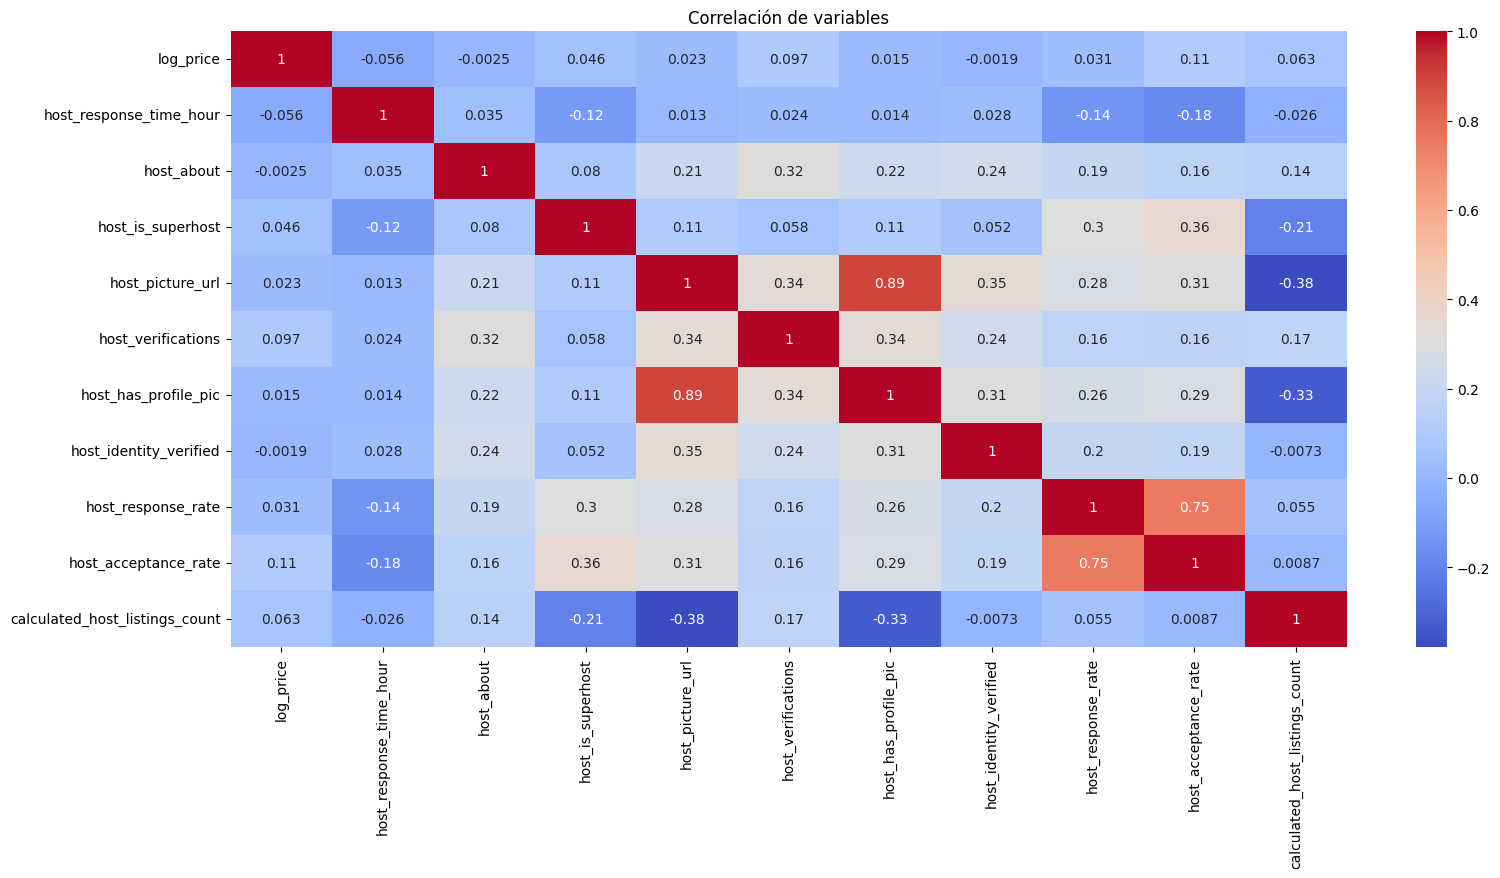

In [34]:
# con esta instrucción lo que hacemos es colocar más grande el mapa de calor
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 10})
hfig, axes = plt.subplots(figsize=(18,8))  
# dibujamos el mapa con las correlaciones de todas las variables
sns.heatmap(alojamientos_gdf[[     
'log_price','host_response_time_hour','host_about', 'host_is_superhost', 'host_picture_url', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified','host_response_rate', 'host_acceptance_rate', 'calculated_host_listings_count'
]].corr(), cmap = 'coolwarm', ax = axes, annot=True) 
plt.title('Correlación de variables')

Text(0.5, 1.0, 'Correlación de variables')

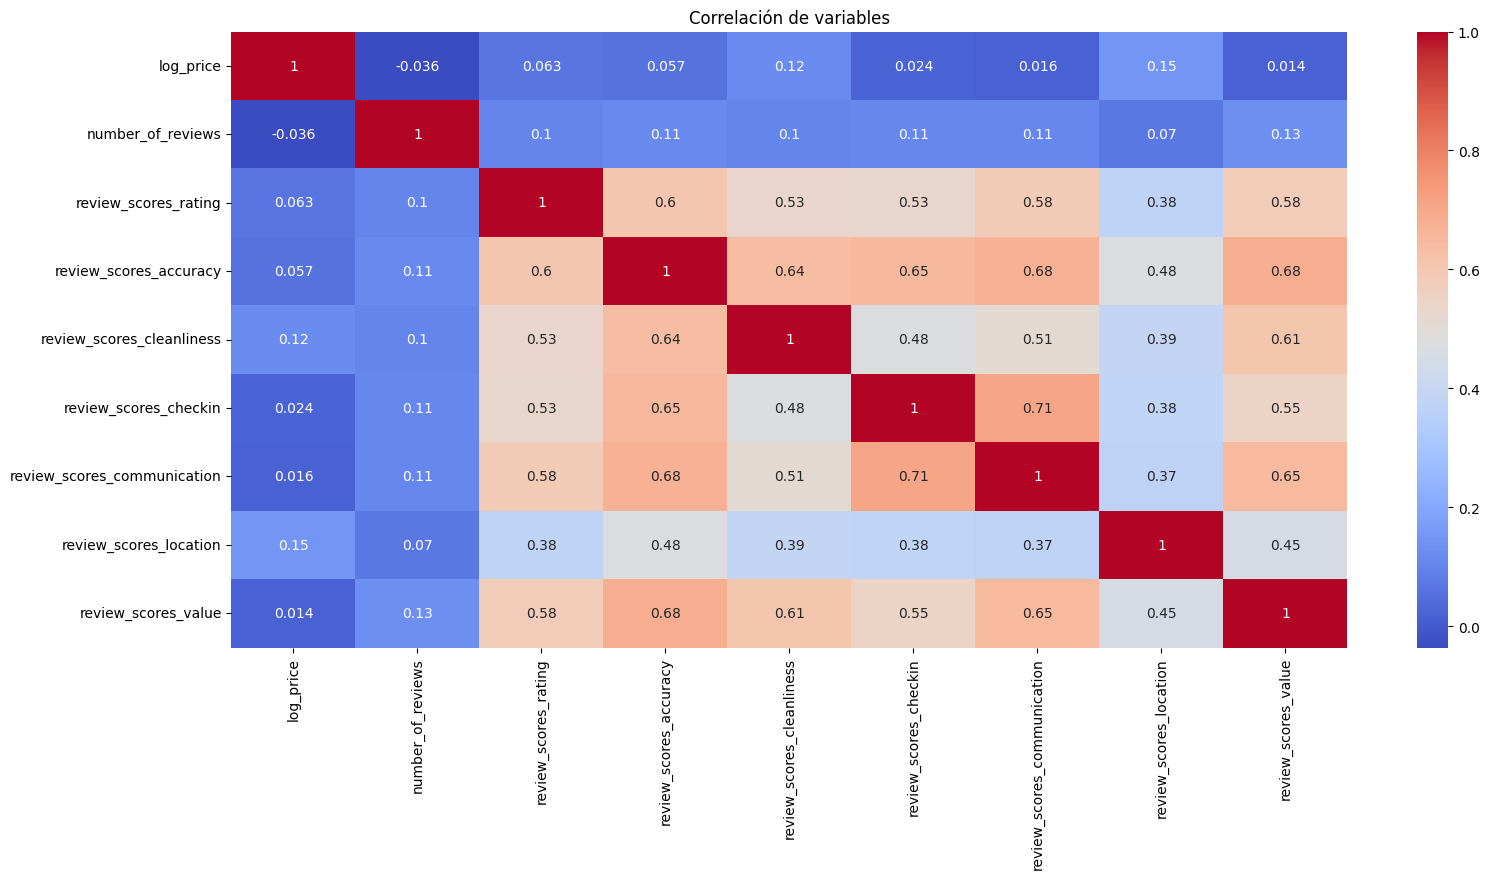

In [35]:
# con esta instrucción lo que hacemos es colocar más grande el mapa de calor
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 10})
hfig, axes = plt.subplots(figsize=(18,8))  
# dibujamos el mapa con las correlaciones de todas las variables
sns.heatmap(alojamientos_gdf[[     
'log_price','number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication','review_scores_location','review_scores_value'
]].corr(), cmap = 'coolwarm', ax = axes, annot=True) 
plt.title('Correlación de variables')

Text(0.5, 1.0, 'Correlación de variables')

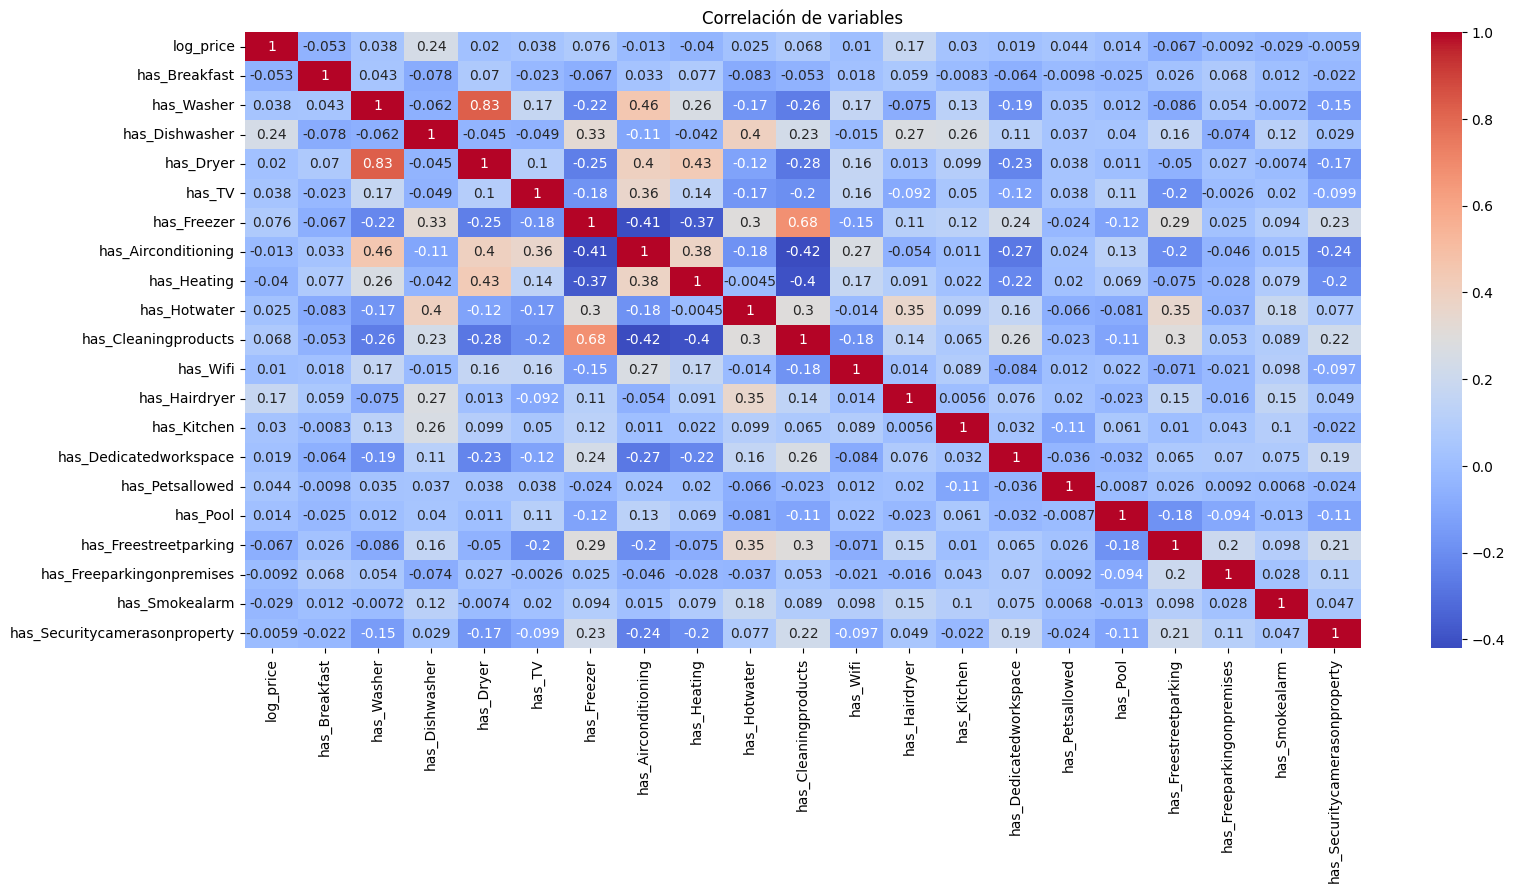

In [36]:
# con esta instrucción lo que hacemos es colocar más grande el mapa de calor
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 10})
hfig, axes = plt.subplots(figsize=(18,8))  
# dibujamos el mapa con las correlaciones de todas las variables
sns.heatmap(alojamientos_gdf[[     
    'log_price','has_Breakfast','has_Washer', 'has_Dishwasher','has_Dryer', 'has_TV', 'has_Freezer','has_Airconditioning','has_Heating','has_Hotwater', 'has_Cleaningproducts','has_Wifi', 'has_Hairdryer','has_Kitchen', 'has_Dedicatedworkspace', 'has_Petsallowed', 'has_Pool', 'has_Freestreetparking', 'has_Freeparkingonpremises','has_Smokealarm', 'has_Securitycamerasonproperty'
]].corr(), cmap = 'coolwarm', ax = axes, annot=True) 
plt.title('Correlación de variables')

Text(0.5, 1.0, 'Correlación de variables')

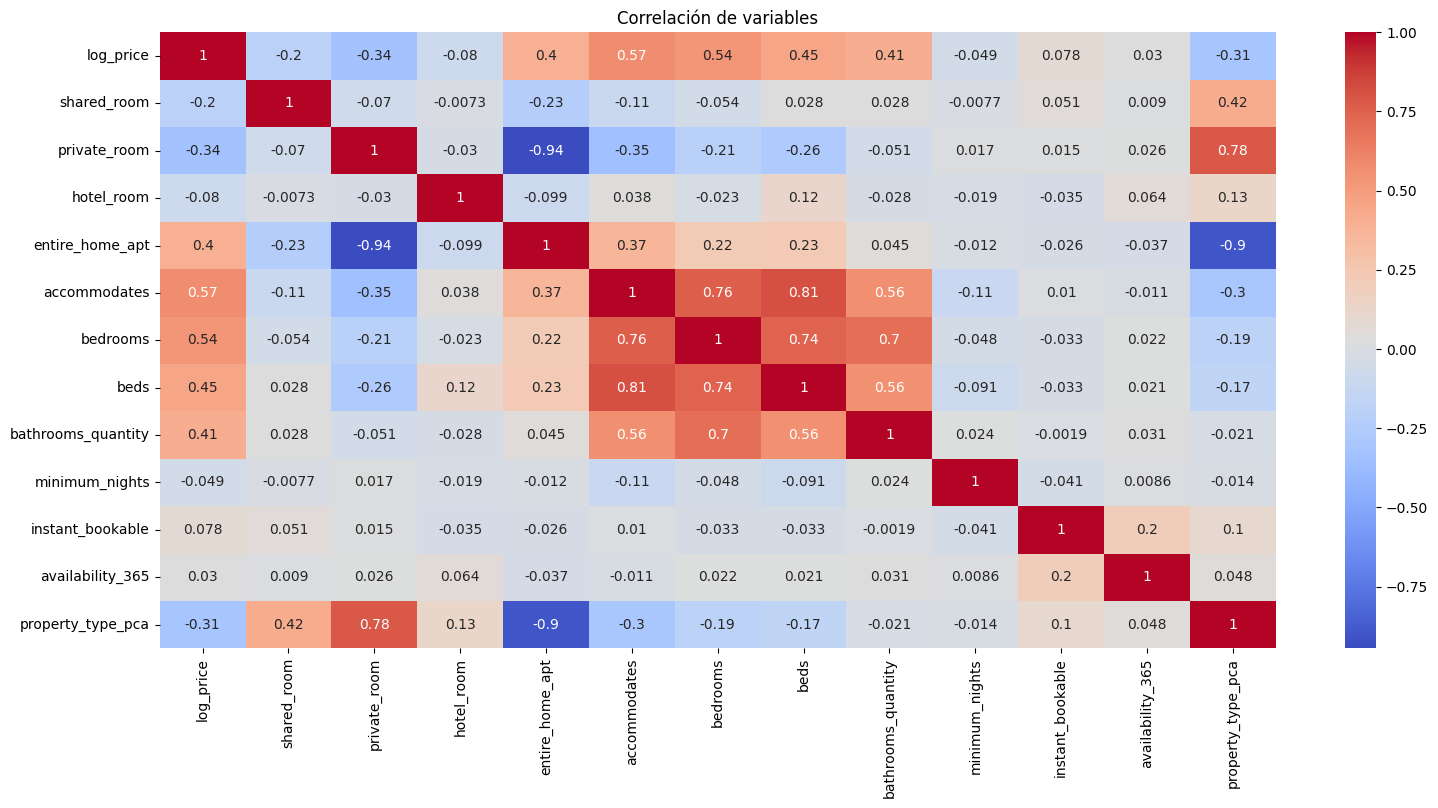

In [37]:
# con esta instrucción lo que hacemos es colocar más grande el mapa de calor
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 10})
hfig, axes = plt.subplots(figsize=(18,8))  

# dibujamos el mapa con las correlaciones de todas las variables
sns.heatmap(alojamientos_gdf[[     
    'log_price','shared_room','private_room','hotel_room','entire_home_apt','accommodates', 'bedrooms',  'beds', 'bathrooms_quantity', 'minimum_nights','instant_bookable', 'availability_365', 'property_type_pca'
]].corr(), cmap = 'coolwarm', ax = axes, annot=True) 
plt.title('Correlación de variables')

Text(0.5, 1.0, 'Correlación de variables')

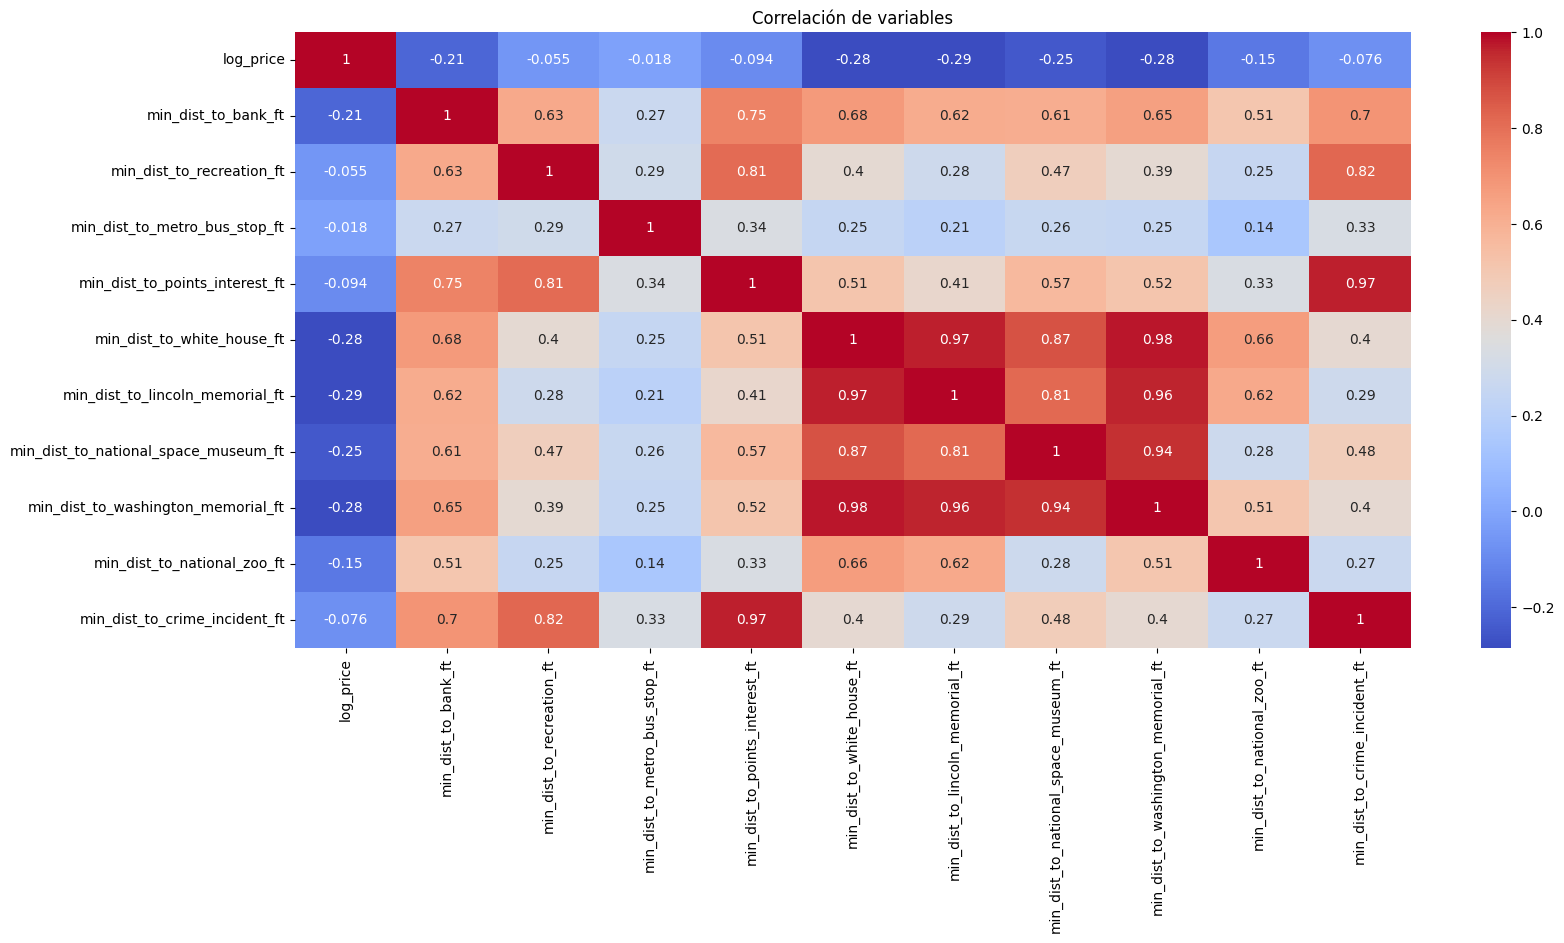

In [38]:
# con esta instrucción lo que hacemos es colocar más grande el mapa de calor
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams.update({'font.size': 10})
hfig, axes = plt.subplots(figsize=(18,8))  
# dibujamos el mapa con las correlaciones de todas las variables
sns.heatmap(alojamientos_gdf[[     
    'log_price','min_dist_to_bank_ft', 'min_dist_to_recreation_ft', 'min_dist_to_metro_bus_stop_ft','min_dist_to_points_interest_ft','min_dist_to_white_house_ft','min_dist_to_lincoln_memorial_ft','min_dist_to_national_space_museum_ft','min_dist_to_washington_memorial_ft','min_dist_to_national_zoo_ft','min_dist_to_crime_incident_ft'
]].corr(), cmap = 'coolwarm', ax = axes, annot=True) 
plt.title('Correlación de variables')

# **Revisión de outliers**

Se observa en el precio una distribución anormal.

Text(0.5, 1.0, 'Distribución del precio de los alojamientos')

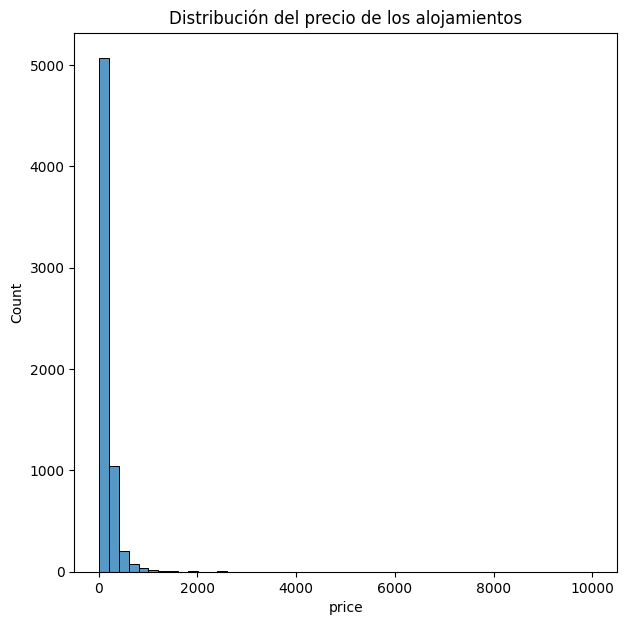

In [39]:
plt.rcParams['figure.figsize'] = [7, 7]
sns.histplot(alojamientos_gdf['price'], bins=50)
plt.title("Distribución del precio de los alojamientos")

El precio convertido a logaritmo se hizo para suavizar los datos y que tenga una distribución normal.

Text(0.5, 1.0, 'Distribución del precio de los alojamientos (logaritmo)')

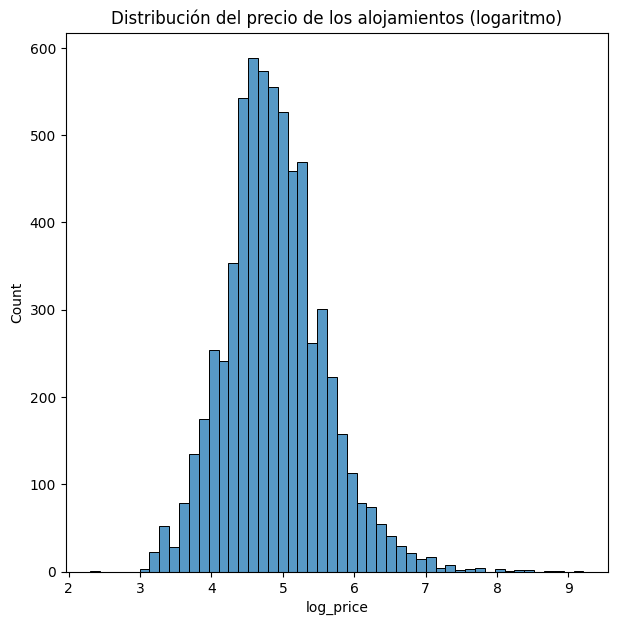

In [40]:
plt.rcParams['figure.figsize'] = [7, 7]
sns.histplot(alojamientos_gdf['log_price'], bins=50)
plt.title("Distribución del precio de los alojamientos (logaritmo)")

Se observa que entre más aumenta el número de personas permitidas en el alojamiento, más incrementa el precio.

Text(0.5, 1.0, 'Número máximo de personas permitidas en el alojamiento vs Precio')

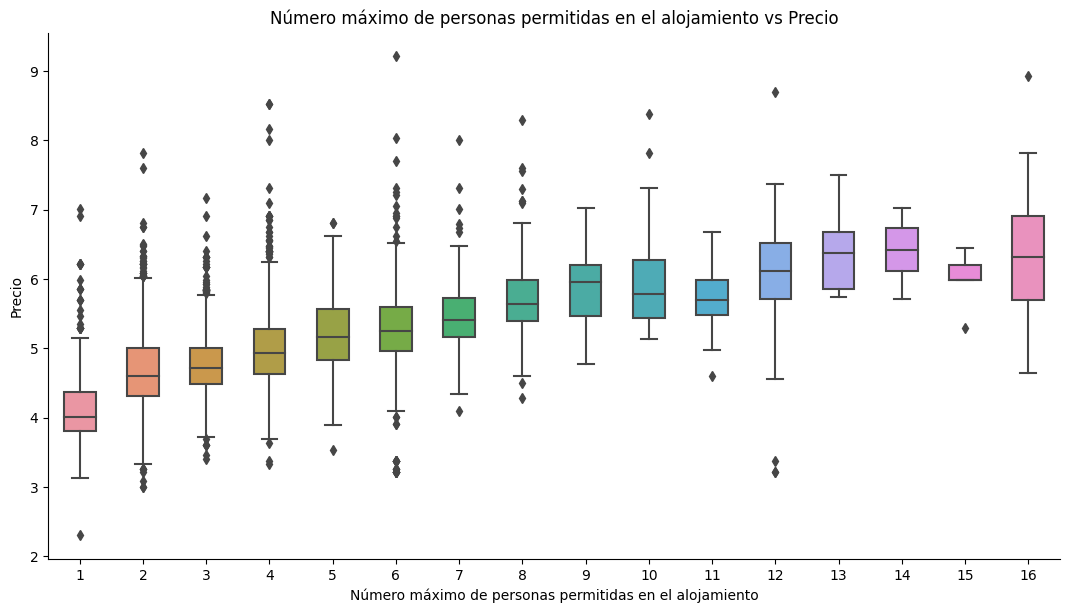

In [41]:
sns.catplot(
    data=alojamientos_gdf, 
    x='accommodates', y='log_price', kind='box',
    height=6, aspect=1.8, width=0.5
)
plt.xlabel("Número máximo de personas permitidas en el alojamiento")
plt.ylabel('Precio')
plt.title('Número máximo de personas permitidas en el alojamiento vs Precio')

Se observa que eñ tipo de habitación "Entire Home/Apto" es el que más alto tiene los precios. Además se observan algunos outliers.

Text(0.5, 1.0, 'Tipo de habitación del alojamiento vs Precio')

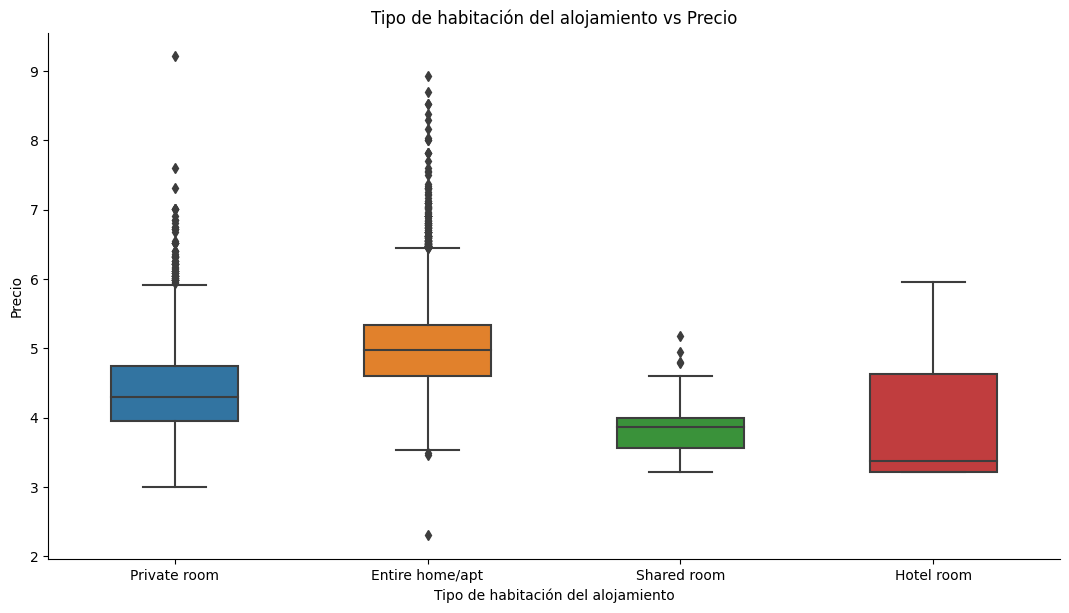

In [42]:
sns.catplot(
    data=alojamientos_gdf, 
    x='room_type', y='log_price', kind='box',
    height=6, aspect=1.8, width=0.5
)
plt.xlabel("Tipo de habitación del alojamiento")
plt.ylabel('Precio')
plt.title('Tipo de habitación del alojamiento vs Precio')

Se observan algunos outliers en cuanto al número de baños del alojamiento.

Text(0.5, 1.0, 'Número de baños del alojamiento vs Precio')

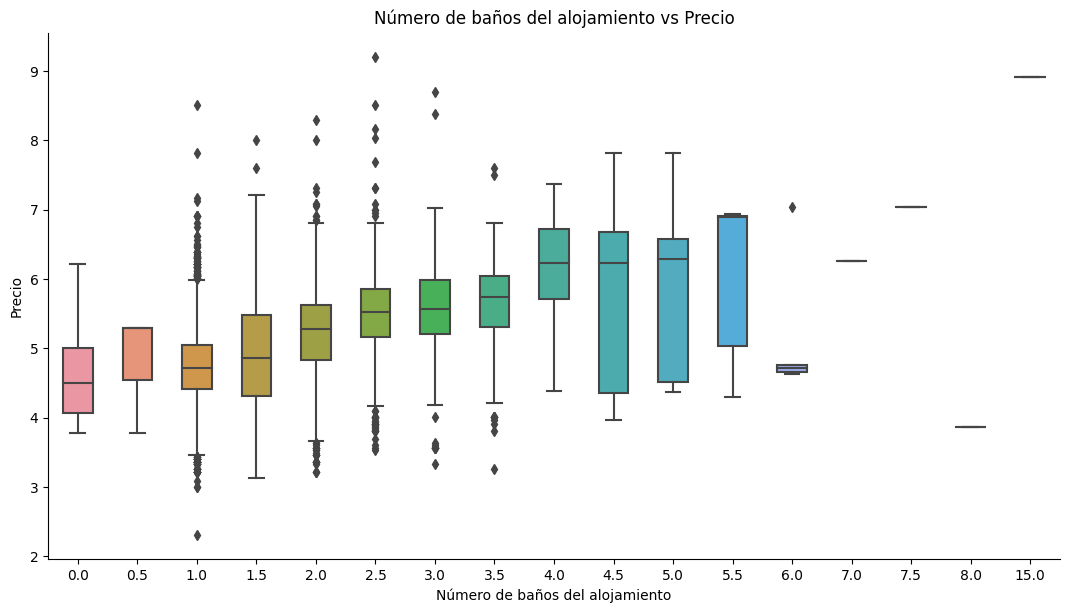

In [43]:
sns.catplot(
    data=alojamientos_gdf, 
    x='bathrooms_quantity', y='log_price', kind='box',
    height=6, aspect=1.8, width=0.5
)
plt.xlabel("Número de baños del alojamiento")
plt.ylabel('Precio')
plt.title('Número de baños del alojamiento vs Precio')

Se observan algunos outliers en cuanto al número de camas del alojamiento.

Text(0.5, 1.0, 'Número de camas del alojamiento vs Precio')

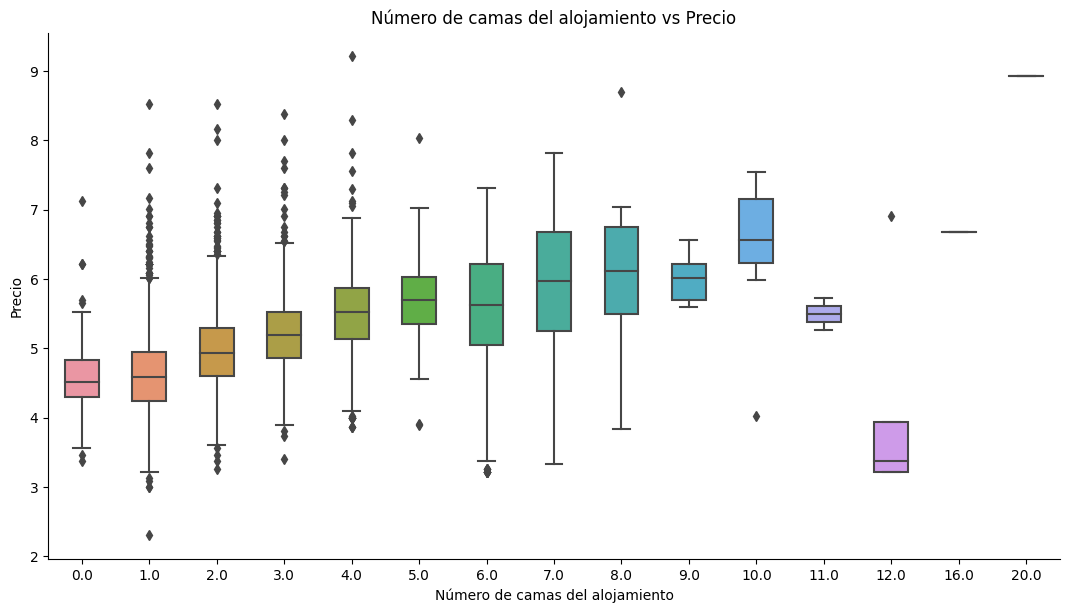

In [44]:
sns.catplot(
    data=alojamientos_gdf, 
    x='beds', y='log_price', kind='box',
    height=6, aspect=1.8, width=0.5
)
plt.xlabel("Número de camas del alojamiento")
plt.ylabel('Precio')
plt.title('Número de camas del alojamiento vs Precio')

Se observan algunos outliers en cuanto al número de habitaciones del alojamiento. Además se ve una tendencia a que entre más habitaciones tiene un alojamiento, más alto será su precio.

Text(0.5, 1.0, 'Número de habitaciones del alojamiento vs Precio')

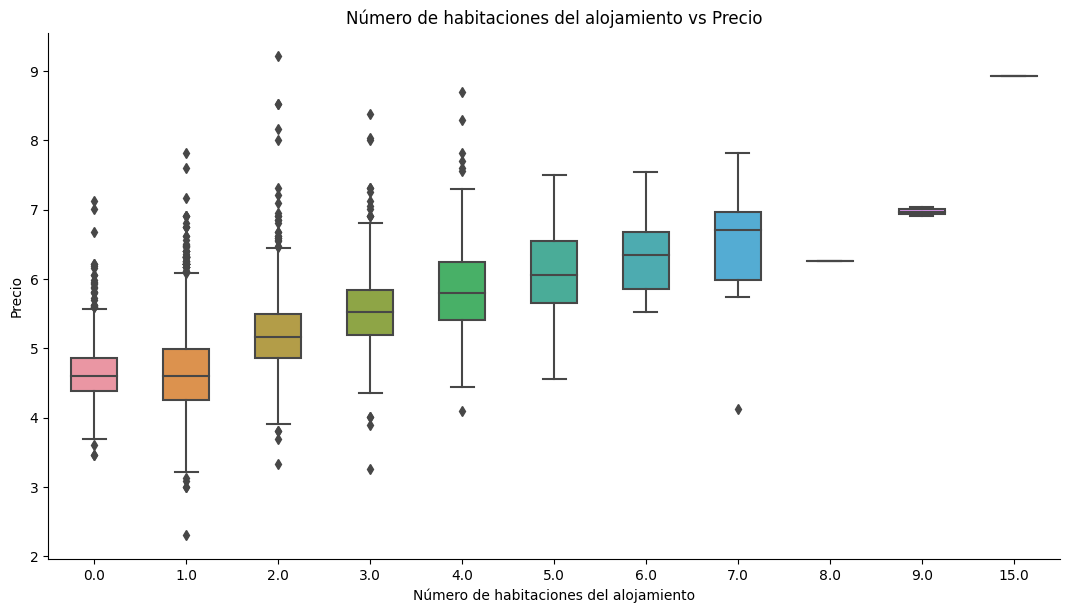

In [45]:
sns.catplot(
    data=alojamientos_gdf, 
    x='bedrooms', y='log_price', kind='box',
    height=6, aspect=1.8, width=0.5
)

plt.xlabel("Número de habitaciones del alojamiento")
plt.ylabel('Precio')
plt.title('Número de habitaciones del alojamiento vs Precio')

# **Análisis**

Text(0.5, 1.0, 'Número de alojamientos de Airbnb por barrio en la ciudad de Washington DC')

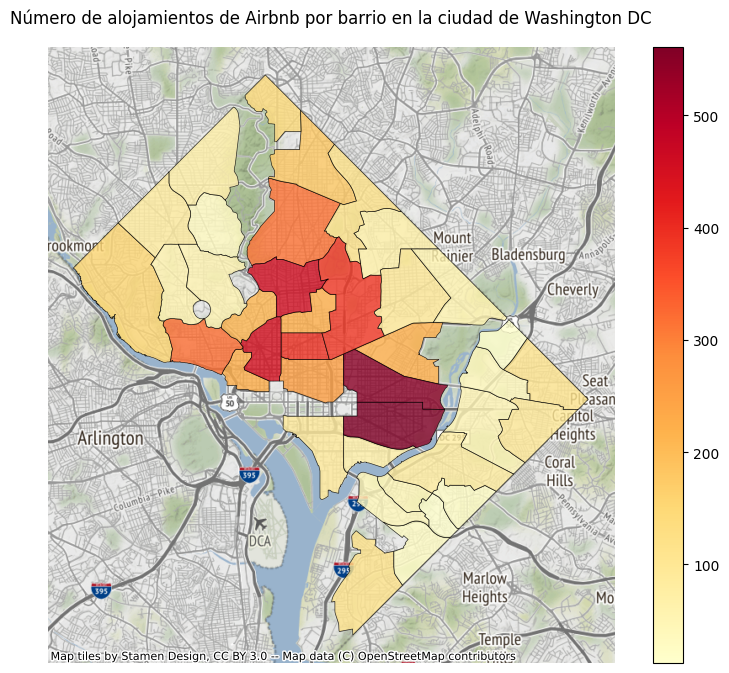

In [46]:
max_alojamientos = vecindarios_airbnb.conteo_alojamientos.max()
tmp_map = vecindarios_airbnb.copy()
tmp_map = tmp_map.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
ax = tmp_map.plot(column='conteo_alojamientos', cmap='YlOrRd', legend=True, ax=ax, alpha=0.8, edgecolor='k',  linewidth=0.5)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.title("Número de alojamientos de Airbnb por barrio en la ciudad de Washington DC")

Text(0.5, 1.0, 'Promedio de precios de alojamientos de Airbnb por barrio en la ciudad de Washington DC')

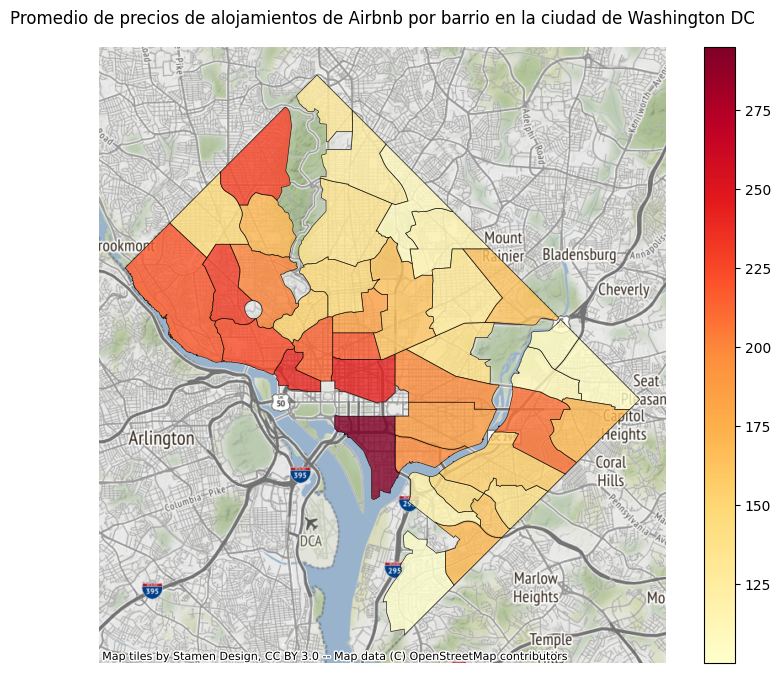

In [47]:
tmp_map = vecindarios_airbnb.copy()
tmp_map = tmp_map.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
ax = tmp_map.plot(column='Precio_Promedio', cmap='YlOrRd', legend=True, ax=ax, alpha=0.8, edgecolor='k',  linewidth=0.5)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.title("Promedio de precios de alojamientos de Airbnb por barrio en la ciudad de Washington DC")

Text(0.5, 1.0, 'Puntaje promedio de alojamientos de Airbnb por barrio en la ciudad de Washington DC')

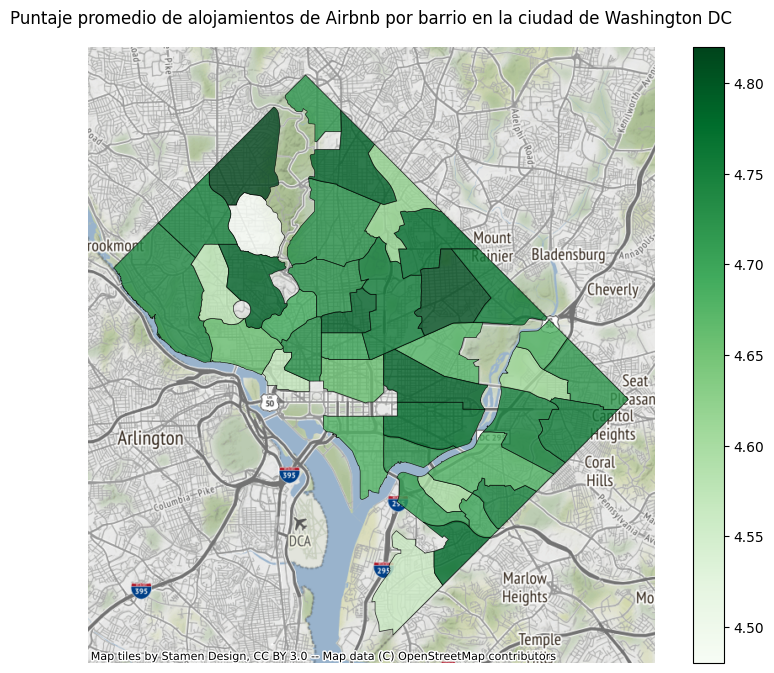

In [48]:
# cmap = 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
tmp_map = vecindarios_airbnb.copy()
tmp_map = tmp_map.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
ax = tmp_map.plot(column='puntaje_promedio', cmap='Greens', legend=True, ax=ax, alpha=0.8, edgecolor='k',  linewidth=0.5)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.title("Puntaje promedio de alojamientos de Airbnb por barrio en la ciudad de Washington DC")

In [49]:
#def definir_color(feature):
#    value = valores_precio.get(feature['properties']['neighbourhood'])
#    return color(value)
#valores_precio = vecindarios_airbnb.set_index('neighbourhood')['Precio_Promedio'].to_dict()
#color = LinearColormap(['yellow','red'], vmin = min(valores_precio.values()), vmax = max(valores_precio.values()))
#fig = folium.Figure(width=800, height=650)
#mapa_precios = folium.Map(location=[38.91545, -77.0305], zoom_start = 12) 
#folium.GeoJson(data = vecindarios_airbnb, name='Washington D.C',
#                tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'Precio_Promedio'],labels=True,sticky=False), style_function = lambda feature: {
#                  'fillColor': definir_color(feature),'color': 'black','weight': 0.5,'dashArray': '3, 3','fillOpacity':0.7
#                },
#                highlight_function=lambda feature: {'weight': 4, 'fillColor': definir_color(feature), 'fillOpacity': 0.4}).add_to(mapa_precios)
#title_html = """<h3 align="center" style="font-size:16px"><b>Mapa de precios de alojamientos por barrios en la ciudad de Washington D.C</b></h3>"""
#fig.get_root().html.add_child(folium.Element(title_html))                
#fig.add_child(mapa_precios)

In [50]:
# Generate scatter plot
#joint_axes = sns.jointplot(
#    x="longitude", y="latitude", data=alojamientos_gdf, s=0.9
#)
#ctx.add_basemap(
#    joint_axes.ax_joint,
#    crs="EPSG:4326",
#    source=ctx.providers.CartoDB.PositronNoLabels,
#)

In [51]:
#alojamientos_gdf.property_type.value_counts()

In [52]:
tmp = alojamientos_gdf.groupby(['property_type'], as_index=False)['number_of_reviews'].count().sort_values(by = 'number_of_reviews', ascending=False)
tmp.head(10)

property_type  number_of_reviews
12           Entire rental unit               2301
9                   Entire home                681
26         Private room in home                571
5                  Entire condo                545
14             Entire townhouse                499
7            Entire guest suite                473
32    Private room in townhouse                282
13    Entire serviced apartment                259
29  Private room in rental unit                232
36       Room in boutique hotel                112

In [53]:
tmp = alojamientos_gdf.groupby(['property_type'], as_index=False)['review_scores_rating'].mean().sort_values(by = 'review_scores_rating', ascending=False)
tmp.head(10)

property_type  review_scores_rating
1                         Camper/RV              5.000000
17                            Floor              4.960000
18                        Houseboat              4.920000
22  Private room in casa particular              4.920000
3                   Casa particular              4.907661
8                 Entire guesthouse              4.894293
7                Entire guest suite              4.837942
0                              Boat              4.830000
19                     Private room              4.815323
39       Room in serviced apartment              4.815000

In [54]:
tmp = alojamientos_gdf.groupby(['room_type'], as_index=False)['number_of_reviews'].count().sort_values(by = 'number_of_reviews', ascending=False)
tmp.head()

room_type  number_of_reviews
0  Entire home/apt               4915
2     Private room               1425
3      Shared room                110
1       Hotel room                 20

Text(0.5, 1.0, 'Número de reviews por tipo de habitación')

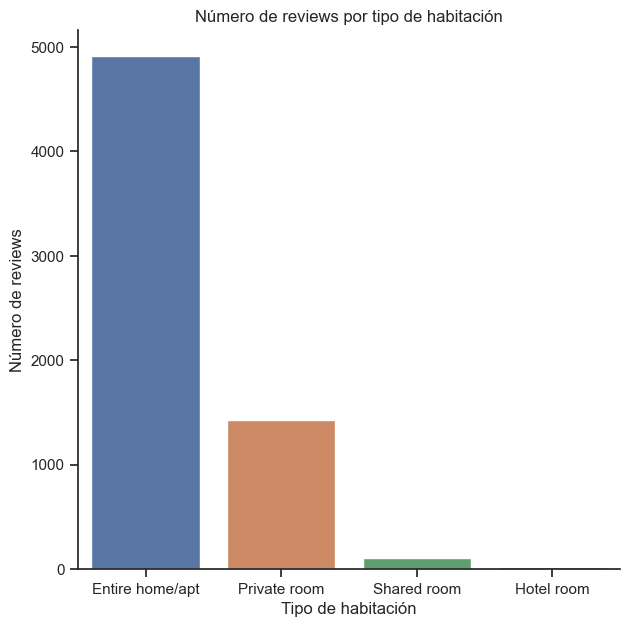

In [55]:
sns.set(rc={'figure.figsize':(7,7)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='room_type', y='number_of_reviews', data=tmp) 

plt.xlabel('Tipo de habitación')
plt.ylabel('Número de reviews')
plt.title('Número de reviews por tipo de habitación')

In [56]:
tmp = alojamientos_gdf.groupby(['room_type'], as_index=False)['review_scores_rating'].mean().sort_values(by = 'review_scores_rating', ascending=False)
tmp.head()

room_type  review_scores_rating
0  Entire home/apt              4.741625
2     Private room              4.676978
1       Hotel room              4.562000
3      Shared room              4.517076

In [57]:
tmp = alojamientos_gdf.groupby(['neighbourhood_cleansed','room_type'], as_index=False)['id'].count().sort_values(by = 'neighbourhood_cleansed', ascending=False)
tmp.head(10)

neighbourhood_cleansed        room_type   id
103                   Woodridge, Fort Lincoln, Gateway     Private room   13
102                   Woodridge, Fort Lincoln, Gateway  Entire home/apt   42
101  Woodland/Fort Stanton, Garfield Heights, Knox ...     Private room    3
100  Woodland/Fort Stanton, Garfield Heights, Knox ...  Entire home/apt    9
99                         West End, Foggy Bottom, GWU      Shared room    2
98                         West End, Foggy Bottom, GWU     Private room   14
97                         West End, Foggy Bottom, GWU  Entire home/apt  209
96           Union Station, Stanton Park, Kingman Park      Shared room   16
95           Union Station, Stanton Park, Kingman Park     Private room   72
94           Union Station, Stanton Park, Kingman Park  Entire home/apt  462

Text(0.5, 1.0, 'Precio por disponibilidad 365')

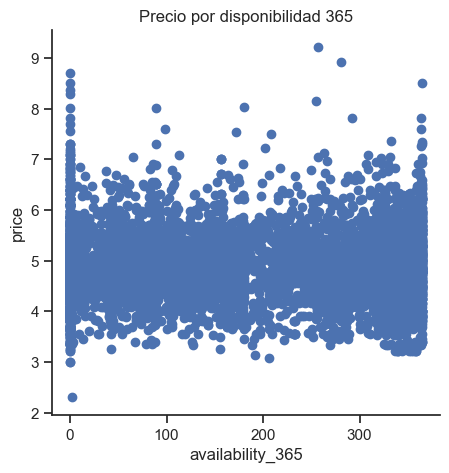

In [58]:
plt.figure(figsize=(5,5))
plt.scatter(x = alojamientos_gdf["availability_365"], y = alojamientos_gdf["log_price"])
plt.xlabel('availability_365', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.title('Precio por disponibilidad 365')

Text(0.5, 1.0, 'Tipo de habitación')

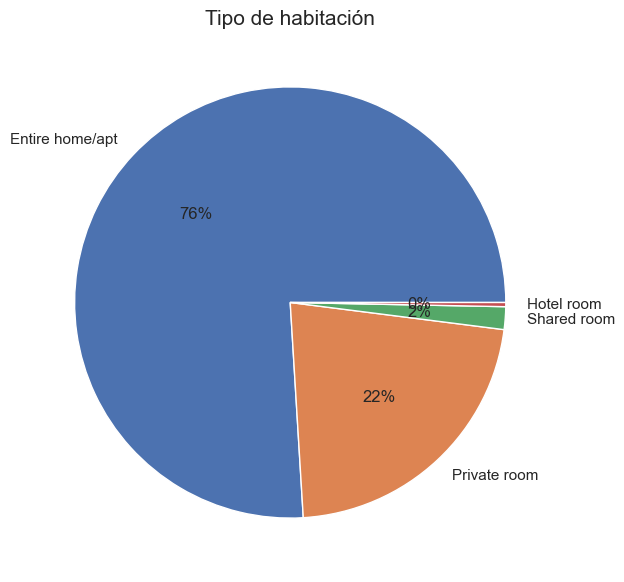

In [59]:
sns.set(rc={'figure.figsize':(7,7)})
tmp = alojamientos_gdf.groupby(['room_type'], as_index=False)['id'].count().sort_values(by = 'id', ascending=False)
plt.pie(tmp["id"], labels = tmp["room_type"], autopct='%.0f%%') #, pctdistance=0.5)
plt.title('Tipo de habitación', fontsize=15)

Text(0.5, 1.0, 'Precio promedio de los distintos tipos de habitación de los alojamientos')

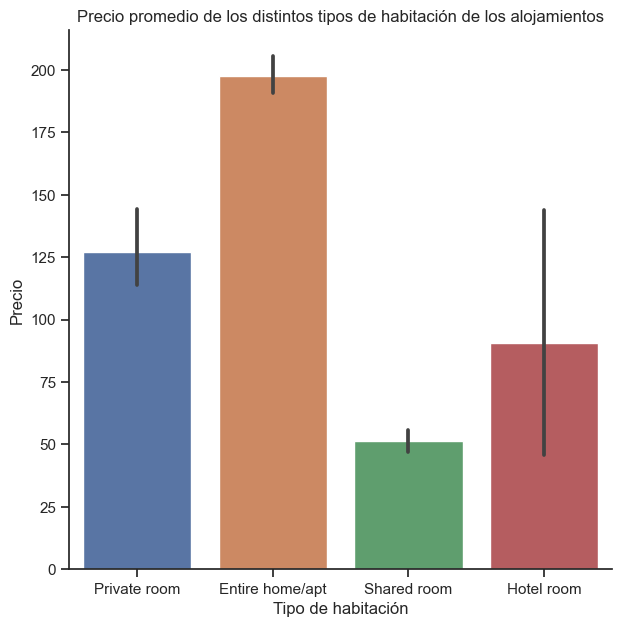

In [60]:
sns.set(rc={'figure.figsize':(7,7)})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='room_type', y='price', data=alojamientos_gdf) #,  palette="muted", orient='h' )
    
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio')
plt.title('Precio promedio de los distintos tipos de habitación de los alojamientos')

In [61]:
tmp = alojamientos_gdf.groupby(['room_type'], as_index=False)['price'].mean().sort_values(by = 'price', ascending=False)
tmp.head(20)

room_type       price
0  Entire home/apt  197.590844
2     Private room  126.905263
1       Hotel room   90.500000
3      Shared room   51.163636

Text(0.5, 1.0, 'price by number_of_reviews')

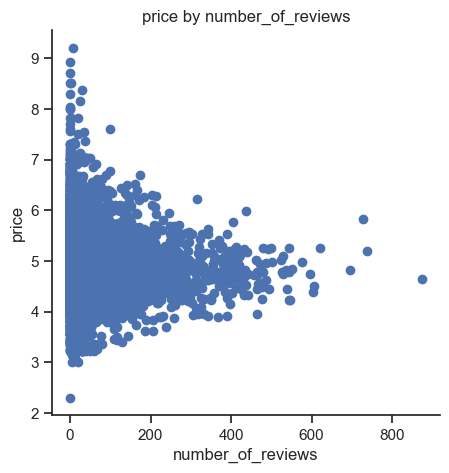

In [62]:
plt.figure(figsize=(5,5))
plt.scatter(x = alojamientos_gdf["number_of_reviews"], y = alojamientos_gdf["log_price"])
plt.xlabel('number_of_reviews', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.title('price by number_of_reviews')

Text(0.5, 1.0, 'Distribución del puntaje de los alojamientos')

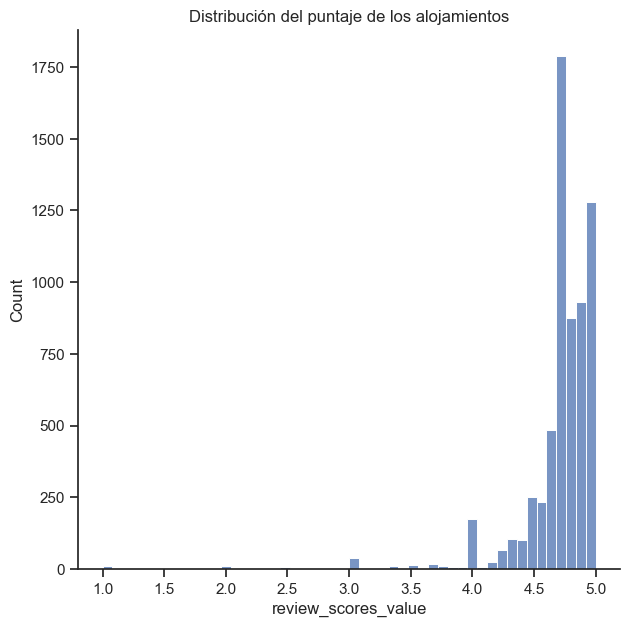

In [63]:
plt.rcParams['figure.figsize'] = [7, 7]
sns.histplot(alojamientos_gdf['review_scores_value'], bins=50)
plt.title('Distribución del puntaje de los alojamientos')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'Entire rental unit'),
  Text(1, 0, 'Entire home'),
  Text(2, 0, 'Private room in home'),
  Text(3, 0, 'Entire condo'),
  Text(4, 0, 'Entire townhouse'),
  Text(5, 0, 'Entire guest suite'),
  Text(6, 0, 'Private room in townhouse'),
  Text(7, 0, 'Entire serviced apartment'),
  Text(8, 0, 'Private room in rental unit'),
  Text(9, 0, 'Room in boutique hotel'),
  Text(10, 0, 'Private room in condo'),
  Text(11, 0, 'Entire guesthouse'),
  Text(12, 0, 'Room in hotel'),
  Text(13, 0, 'Shared room in rental unit'),
  Text(14, 0, 'Private room in guest suite'),
  Text(15, 0, 'Entire loft'),
  Text(16, 0, 'Private room in bed and breakfast'),
  Text(17, 0, 'Shared room in townhouse'),
  Text(18, 0, 'Shared room in home'),
  Text(19, 0, 'Shared room in host

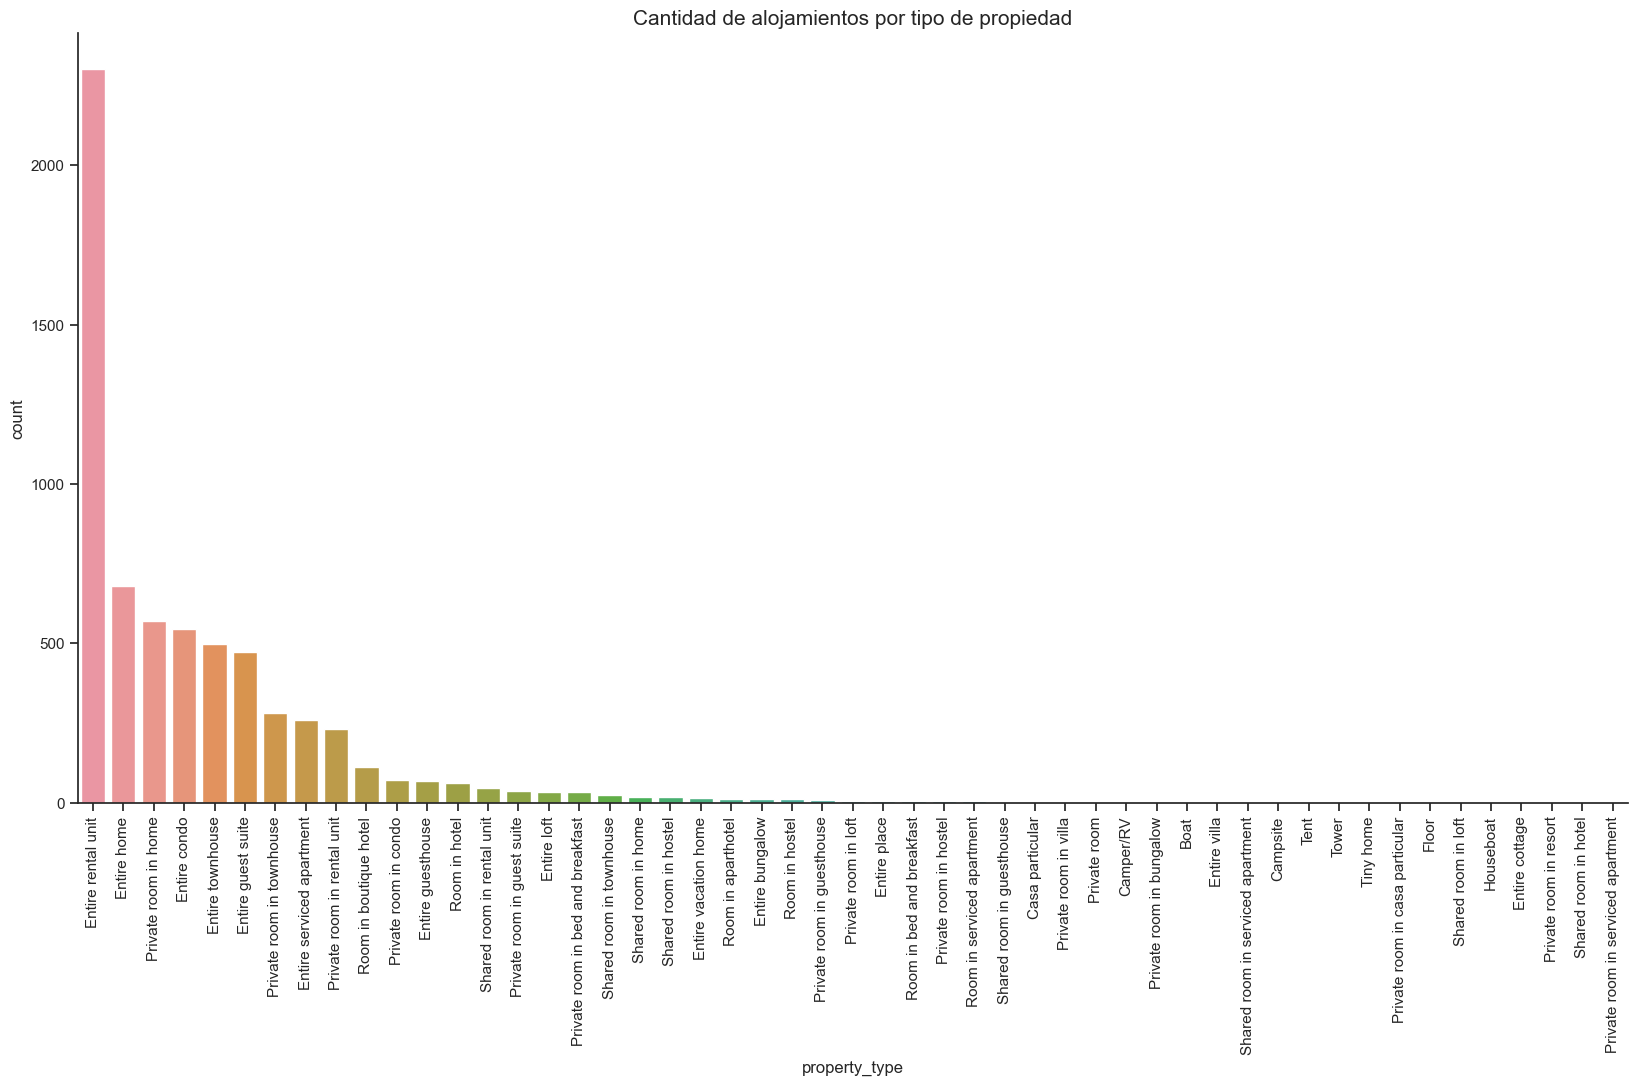

In [64]:
plt.figure(figsize=(20,10))
ax = sns.countplot(data = alojamientos_gdf, x='property_type', order = alojamientos_gdf['property_type'].value_counts().index)
ax.set_title("Cantidad de alojamientos por tipo de propiedad", fontsize=15)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Entire home/apt'),
  Text(1, 0, 'Private room'),
  Text(2, 0, 'Shared room'),
  Text(3, 0, 'Hotel room')])

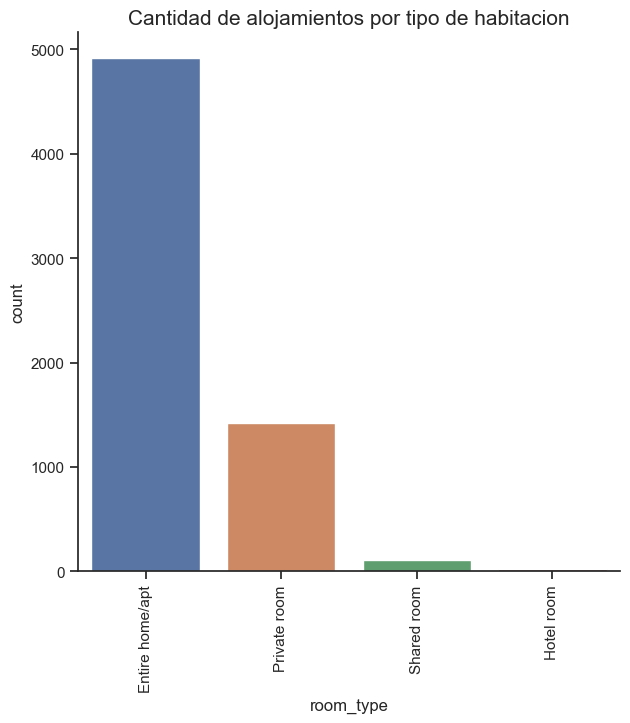

In [65]:
plt.figure(figsize=(7,7))
ax = sns.countplot(data = alojamientos_gdf, x='room_type', order = alojamientos_gdf['room_type'].value_counts().index)
ax.set_title("Cantidad de alojamientos por tipo de habitacion", fontsize=15)
plt.xticks(rotation = 90)

Text(0.5, 1.0, 'bathrooms_quantity vs price')

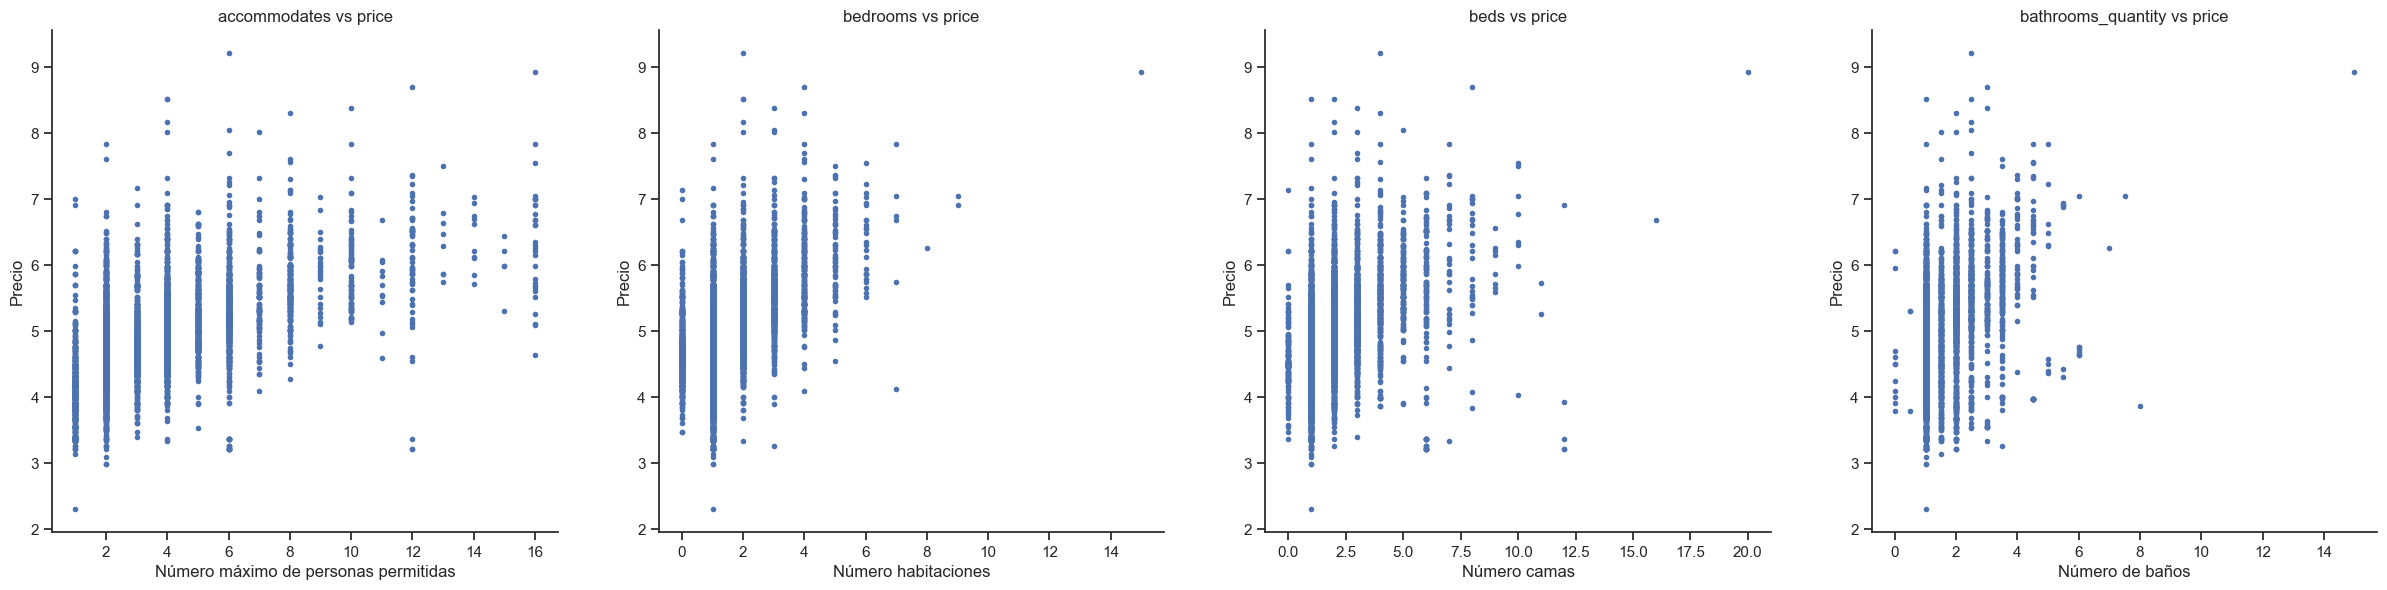

In [66]:
plt.rcParams['figure.figsize'] = [30, 30]

plt.subplot(4, 4, 1)
plt.plot(alojamientos_gdf["accommodates"], alojamientos_gdf["log_price"], marker='.', linestyle='none')
plt.xlabel("Número máximo de personas permitidas")
plt.ylabel('Precio')
plt.title('accommodates vs price')

plt.subplot(4, 4, 2)
plt.plot(alojamientos_gdf["bedrooms"], alojamientos_gdf["log_price"], marker='.', linestyle='none')
plt.xlabel("Número habitaciones")
plt.ylabel('Precio')
plt.title('bedrooms vs price')

plt.subplot(4, 4, 3)
plt.plot(alojamientos_gdf["beds"], alojamientos_gdf["log_price"], marker='.', linestyle='none')
plt.xlabel("Número camas")
plt.ylabel('Precio')
plt.title('beds vs price')

plt.subplot(4, 4, 4)
plt.plot(alojamientos_gdf["bathrooms_quantity"], alojamientos_gdf["log_price"], marker='.', linestyle='none')
plt.xlabel("Número de baños")
plt.ylabel('Precio')
plt.title('bathrooms_quantity vs price')

<AxesSubplot: title={'center': 'Top 10 de vecindarios con mayor cantidad de alojamientos'}>

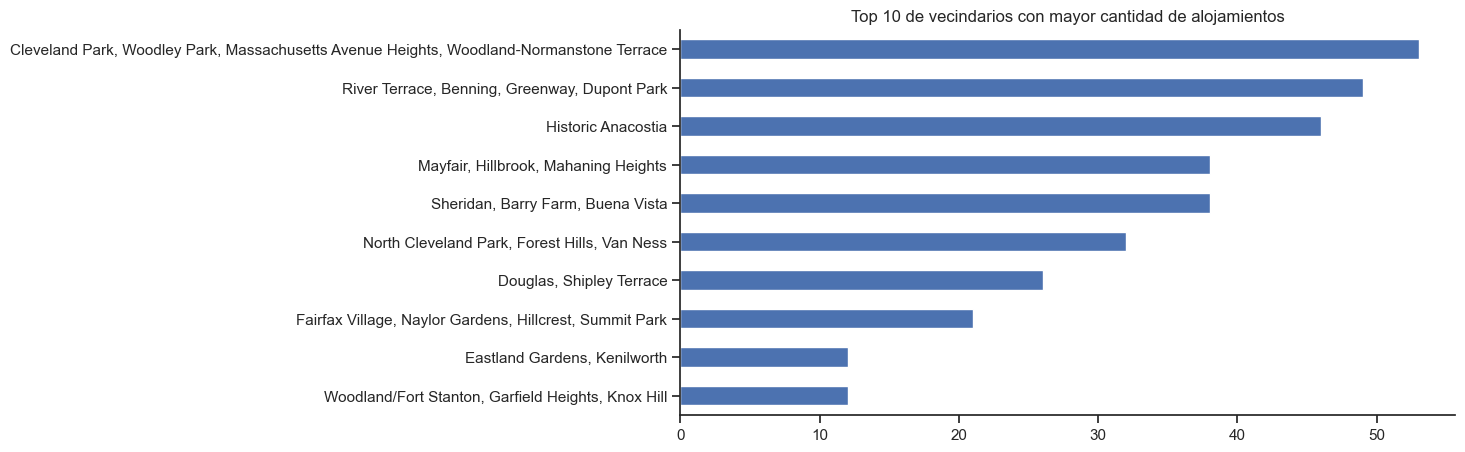

In [67]:
alojamientos_gdf['neighbourhood_cleansed'].value_counts().sort_values().head(10).plot(kind='barh', figsize=(10,5), title="Top 10 de vecindarios con mayor cantidad de alojamientos")

Text(0.5, 1.0, 'Identidad de los hosts')

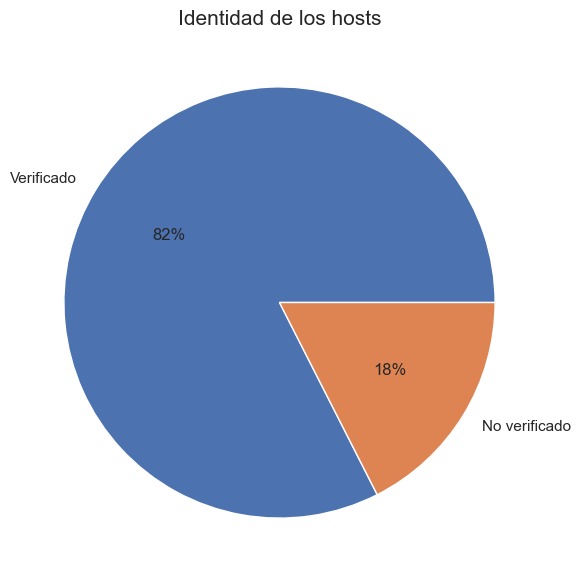

In [68]:
sns.set(rc={'figure.figsize':(7,7)})
tmp = alojamientos_gdf.groupby(['host_identity_verified'], as_index=False)['id'].count().sort_values(by = 'id', ascending=False)
tmp['host_identity_verified'] = tmp['host_identity_verified'].replace(to_replace=[1, 0], value=["Verificado", "No verificado"])
plt.pie(tmp["id"], labels = tmp["host_identity_verified"], autopct='%.0f%%') #, pctdistance=0.5)
plt.title('Identidad de los hosts', fontsize=15)

In [69]:
latitudes_dc = alojamientos_gdf['latitude'].tolist()
longitudes_dc = alojamientos_gdf['longitude'].tolist()
puntos_mapa = list(zip(latitudes_dc, longitudes_dc))

# le colocamos latitud y longitud de washington para que el mapa inicie ahi
fig = folium.Figure(width=800, height=650)
mapa_recreation_facilities = folium.Map(location=[38.91545, -77.0305], zoom_start = 12) 

folium.GeoJson(
    data = vecindarios_airbnb, name='Washington D.C', 
    tooltip = folium.features.GeoJsonTooltip(fields=['neighbourhood', 'Precio_Promedio'],labels=True,sticky=False), 
    style_function = lambda feature: {'fillColor': '#E5E7E9','color': 'black','weight': 0.5,'dashArray': '3, 3','fillOpacity':0.7},
    highlight_function=lambda feature: {'weight': 2, 'fillColor': '#AF7AC5', 'fillOpacity': 0.4}
).add_to(mapa_recreation_facilities)

FastMarkerCluster(data = puntos_mapa).add_to(mapa_recreation_facilities)

folium.GeoJson(
    data = recreation_facilities, name='Washington D.C', 
    marker = folium.CircleMarker(radius = 5,weight = 0,fill_color = '#000000',fill_opacity = 1),
    tooltip = folium.features.GeoJsonTooltip(fields=['NAME'],labels=True,sticky=False), 
    style_function = lambda x: {'fillColor': '#6E2C00'}
).add_to(mapa_recreation_facilities)

folium.GeoJson(
    data = bank_location, name='Washington D.C', 
    marker = folium.CircleMarker(radius = 5,weight = 0,fill_color = '#000000',fill_opacity = 1),
    tooltip = folium.features.GeoJsonTooltip(fields=['NAME', 'ADDRESS'],labels=True,sticky=False), 
    style_function=lambda x: {'fillColor': '#DC7633'}
).add_to(mapa_recreation_facilities)

#folium.GeoJson(
#    data = metro_bus_stop, name='Washington D.C', 
#    marker = folium.CircleMarker(radius = 5,weight = 0,fill_color = '#000000',fill_opacity = 1),    
#    style_function=lambda x: {'fillColor': '#1785c5'}
#).add_to(mapa_recreation_facilities)

title_html = """
    <h3 align="center" style="font-size:16px"><b>Mapa de instalaciones recreativas, bancos, lineas de metro en la ciudad de Washington D.C</b></h3>
    <table style="margin:10px">
        <tr>
            <td><div style="background-color: #6E2C00; width: 10px; height: 10px; float:left"></div></td>
            <td>Instalaciones para recreación</td>
        </tr>
        
        <tr>
            <td><div style="background-color: #DC7633; width: 10px; height: 10px; float:left"></div></td>
            <td>Localización de bancos</td>
        </tr>
        
        <tr>
            <td><div style="border-bottom-style: solid; border-bottom-color: #1785c5; width: 10px; height: 10px; float:left"></div></td>
            <td>Lineas de metro</td>
        </tr>
    </table>
"""
fig.get_root().html.add_child(folium.Element(title_html))                
fig.add_child(mapa_recreation_facilities)

# **Selección de características**

Se elegirán aquellas características más relevantes para el modelo.

In [70]:
tmp_caracteristicas = [
# variable dependiente
'log_price',

# características del alojamiento
'shared_room',
'private_room',
'hotel_room',
'entire_home_apt',
'accommodates', 
'bedrooms',  
'beds', 
'bathrooms_quantity', 
'minimum_nights',
'instant_bookable', 
'availability_365', 
'property_type_pca',

# Características de servicios adicionales
'has_Breakfast',
'has_Washer', 
'has_Dishwasher',
'has_Dryer', 
'has_TV', 
'has_Freezer', 
'has_Airconditioning', 
'has_Heating',
'has_Hotwater', 
'has_Cleaningproducts',
'has_Wifi', 
'has_Hairdryer',
'has_Kitchen', 
'has_Dedicatedworkspace', 
'has_Petsallowed', 
'has_Pool', 
'has_Freestreetparking', 
'has_Freeparkingonpremises',
'has_Smokealarm', 
'has_Securitycamerasonproperty', 

# Características de calificaciones del huesped
'number_of_reviews', 
'review_scores_rating', 
'review_scores_accuracy', 
'review_scores_cleanliness',
'review_scores_checkin', 
'review_scores_communication',
'review_scores_location',
'review_scores_value',

# Caracteristicas del host
'host_response_time_hour',
'host_about', 
'host_is_superhost', 
'host_picture_url', 
'host_verifications', 
'host_has_profile_pic', 
'host_identity_verified',
'host_response_rate', 
'host_acceptance_rate', 
'calculated_host_listings_count',

# Caracteristicas de ubicación
'min_dist_to_bank_ft', 
'min_dist_to_recreation_ft', 
'min_dist_to_metro_bus_stop_ft',
'min_dist_to_points_interest_ft',
'min_dist_to_white_house_ft',
'min_dist_to_lincoln_memorial_ft',
'min_dist_to_national_space_museum_ft',
'min_dist_to_washington_memorial_ft',
'min_dist_to_national_zoo_ft',
'min_dist_to_crime_incident_ft'

]

# **Regresión**

Normalización de los datos

In [71]:
tmp_mms_alojamientos_gdf = MinMaxScaler().fit_transform(alojamientos_gdf[tmp_caracteristicas])
MMS_alojamientos_gdf = pd.DataFrame(tmp_mms_alojamientos_gdf, index=alojamientos_gdf[tmp_caracteristicas].index, columns=alojamientos_gdf[tmp_caracteristicas].columns)

**Regresión OLS**

In [72]:
reg_exp = f"log_price ~ {' + '.join(MMS_alojamientos_gdf.columns[1:])}"
model = smf.ols(formula=reg_exp, data=MMS_alojamientos_gdf)
results_formula = model.fit()

Se agregarán los resultados de la regresión OLS a una estructura para su posterior análisis.

In [73]:
RESULTADOS = pd.DataFrame(columns=['caracteristica'])
for caracteristica in tmp_caracteristicas:
    if caracteristica != 'log_price':
        RESULTADOS = pd.concat([pd.DataFrame([[caracteristica]], columns=RESULTADOS.columns), RESULTADOS], ignore_index=True)
RESULTADOS.set_index("caracteristica", inplace=True)

for caracteristica in tmp_caracteristicas:
    if caracteristica != 'log_price':
        RESULTADOS.loc[caracteristica, ["intercept_OLS"] ] = round(results_formula.params["Intercept"], 4)
        RESULTADOS.loc[caracteristica, ["coeficiente_OLS"] ] = round(results_formula.params[caracteristica], 4)
        RESULTADOS.loc[caracteristica, ["pvalue_OLS"] ] = round(results_formula.pvalues[caracteristica], 4)
        RESULTADOS.loc[caracteristica, ["lower_OLS"] ] = round(results_formula.conf_int().loc[caracteristica][0], 4)
        RESULTADOS.loc[caracteristica, ["upper_OLS"] ] = round(results_formula.conf_int().loc[caracteristica][1], 4)

**Regresión Cualtilica**

Se agregarán los resultados de la regresión cuantílica a una estructura para su posterior análisis.

In [74]:
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
reg_exp = f"log_price ~ {' + '.join(MMS_alojamientos_gdf.columns[1:])}"

for q in quantiles:
    quantile_model = smf.quantreg(formula=reg_exp, data=MMS_alojamientos_gdf).fit(q=q)
    for caracteristica in tmp_caracteristicas:
        if caracteristica != 'log_price':
            RESULTADOS.loc[caracteristica, ["coeficiente_"+str(q)] ] = round(quantile_model.params[caracteristica], 4)
            RESULTADOS.loc[caracteristica, ["intercept_"+str(q)] ] = round(quantile_model.params["Intercept"], 4)
            RESULTADOS.loc[caracteristica, ["lower_"+str(q)] ] = round(quantile_model.conf_int().loc[caracteristica][0], 4)
            RESULTADOS.loc[caracteristica, ["upper_"+str(q)] ] = round(quantile_model.conf_int().loc[caracteristica][1], 4)
            RESULTADOS.loc[caracteristica, ["pvalue_"+str(q)] ] = round(quantile_model.pvalues[caracteristica], 4)

Gráficas de la regresión cuantílica

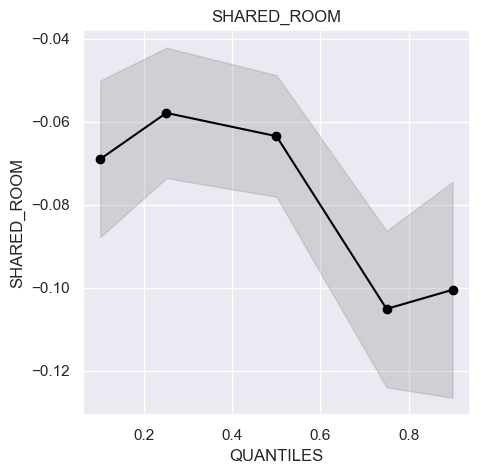

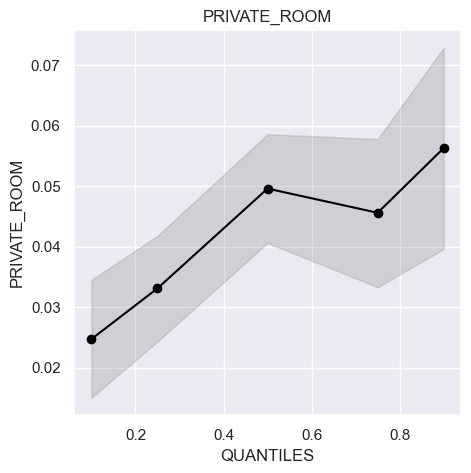

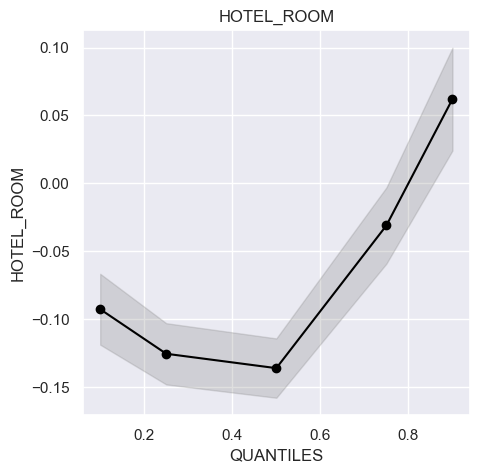

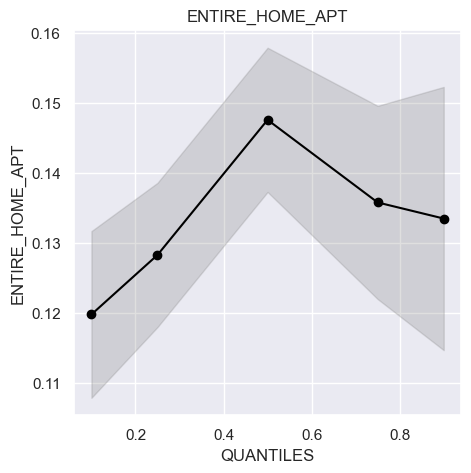

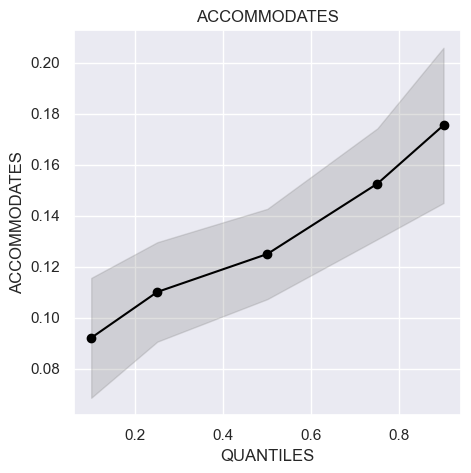

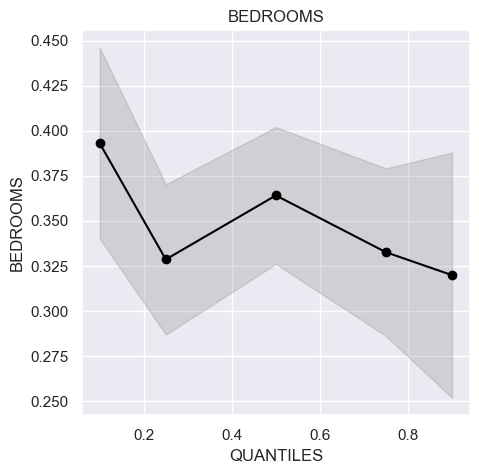

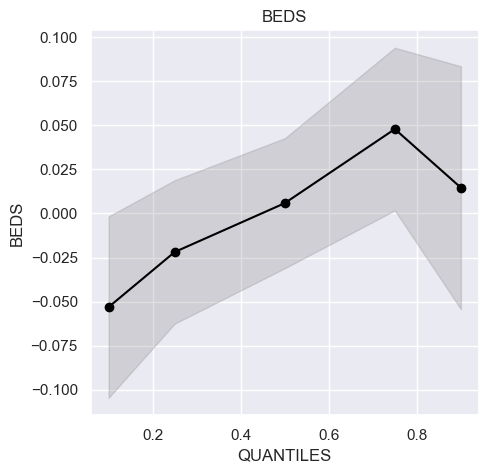

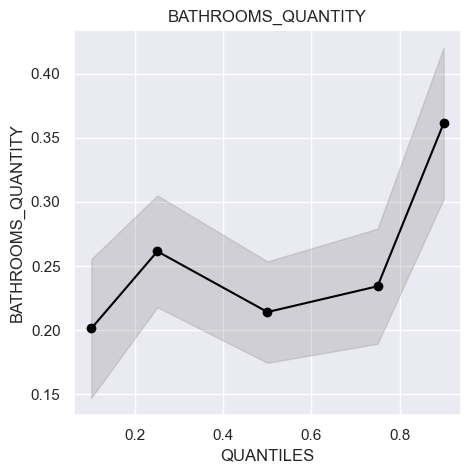

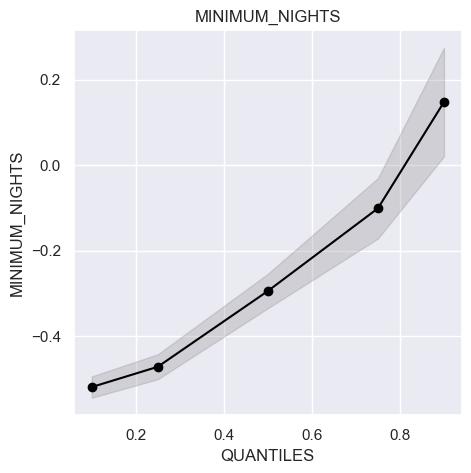

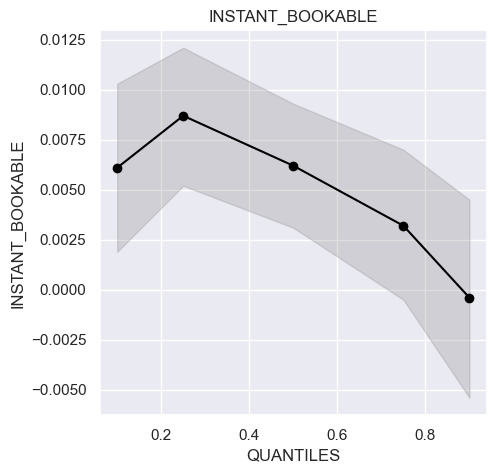

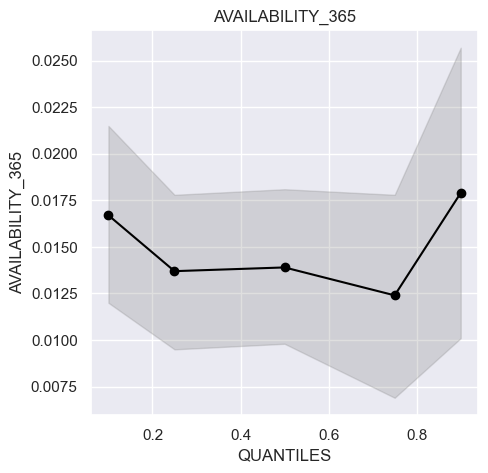

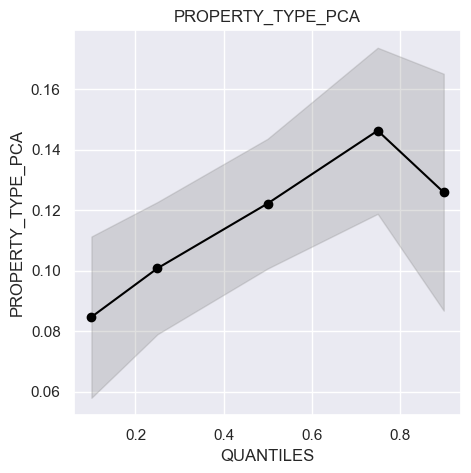

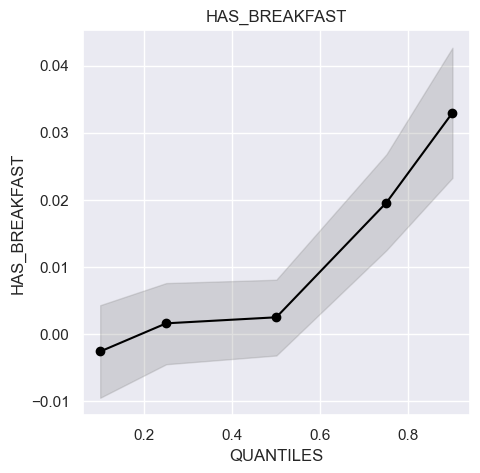

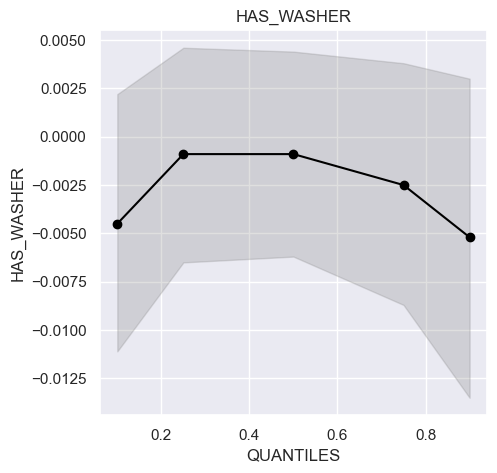

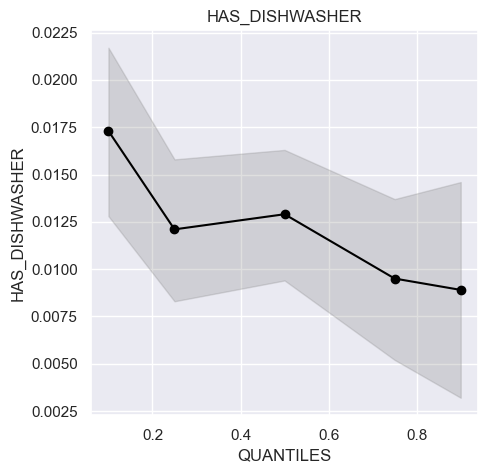

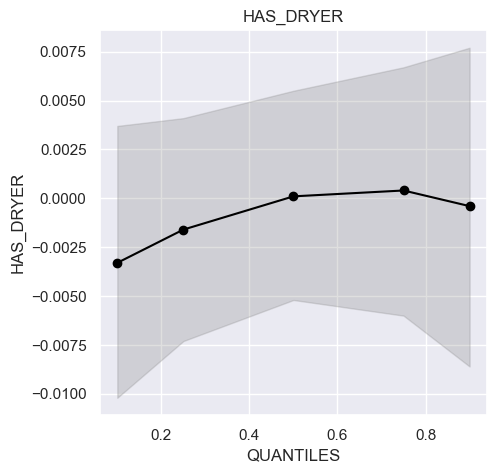

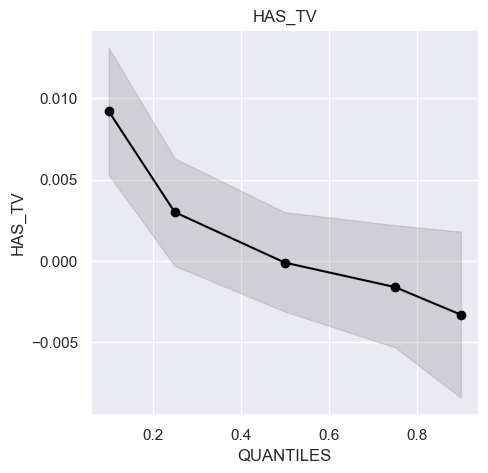

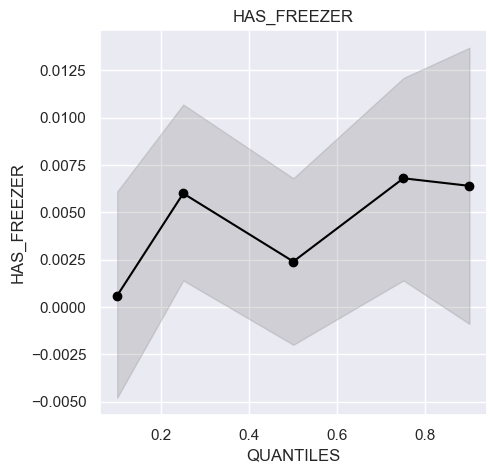

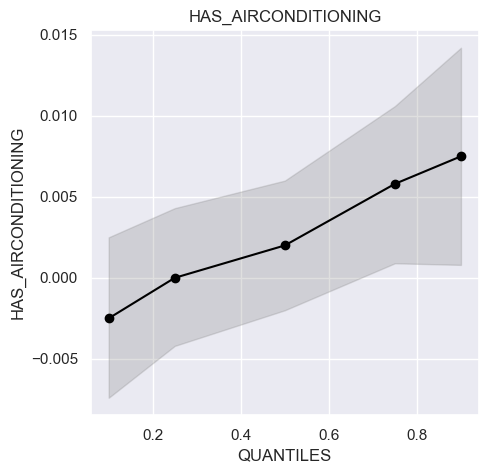

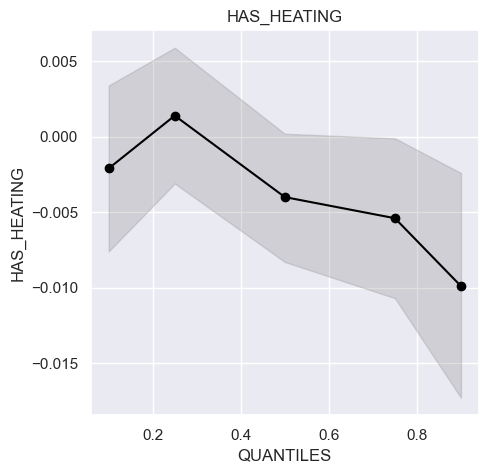

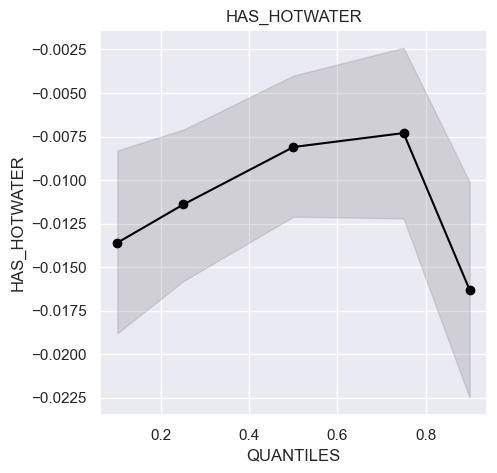

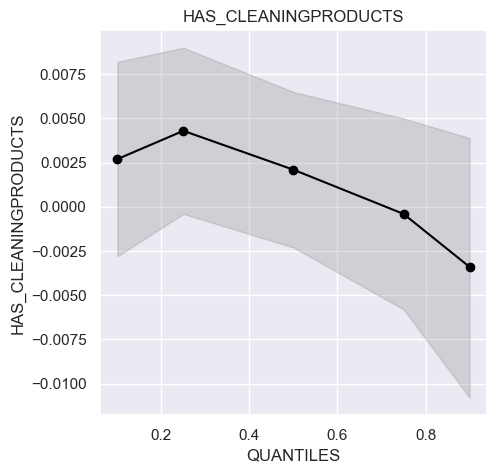

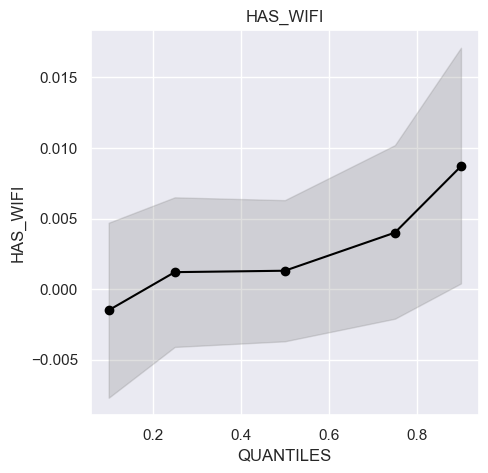

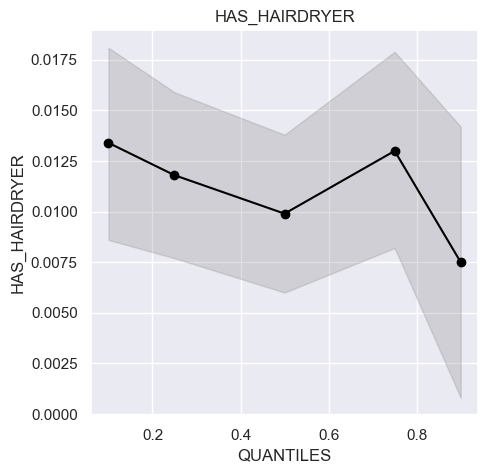

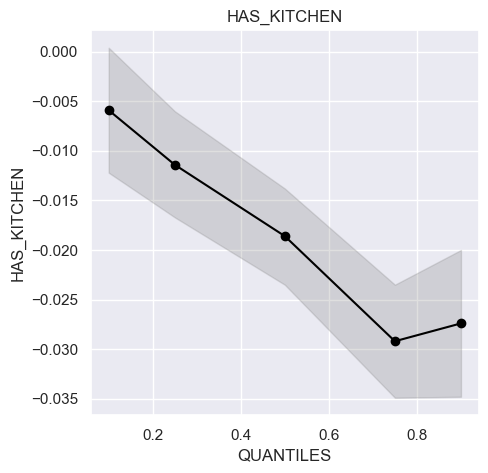

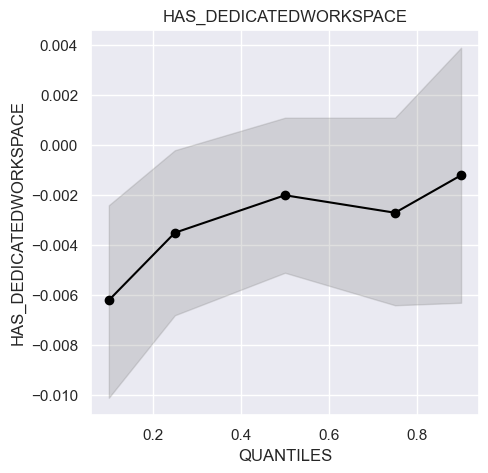

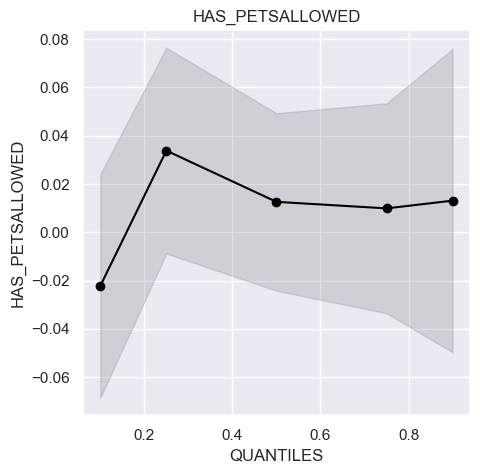

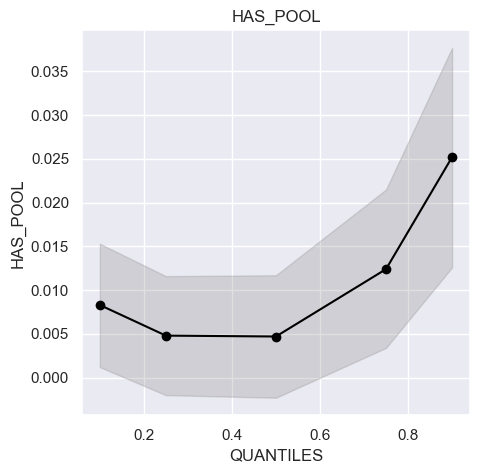

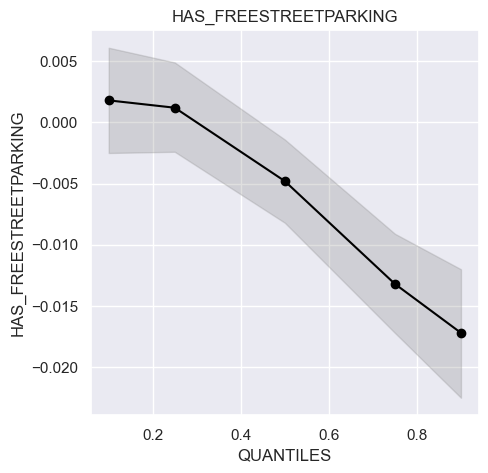

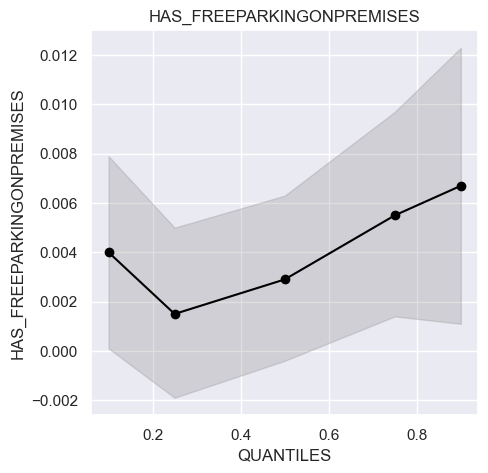

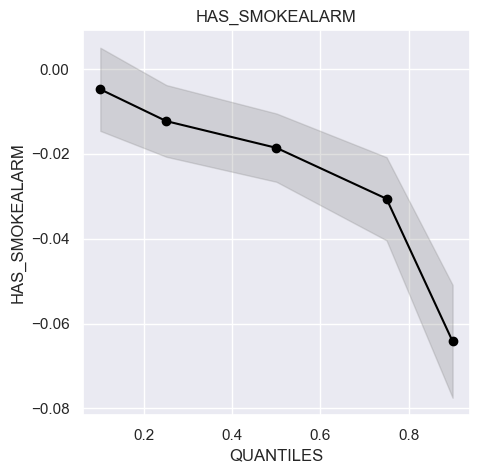

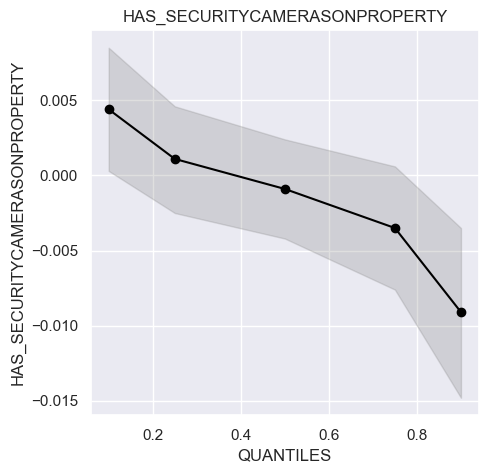

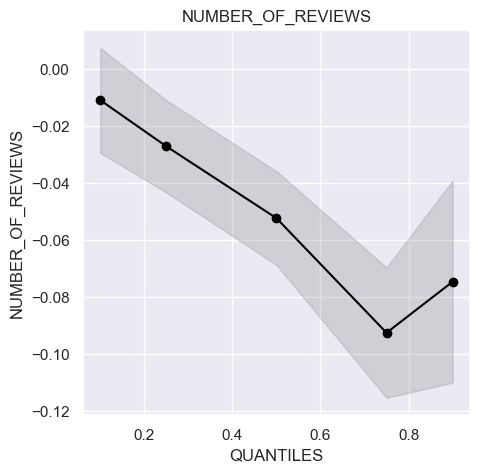

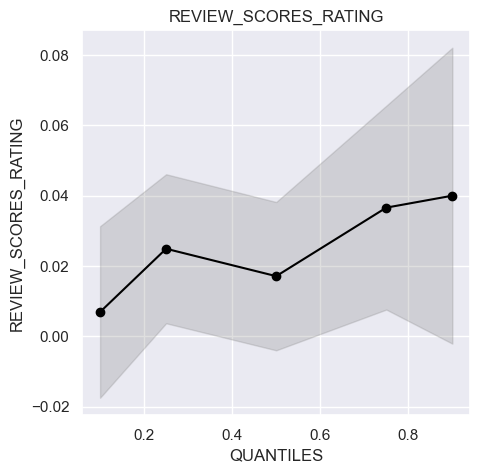

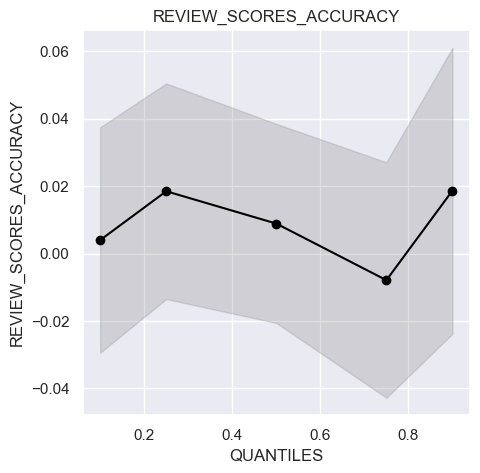

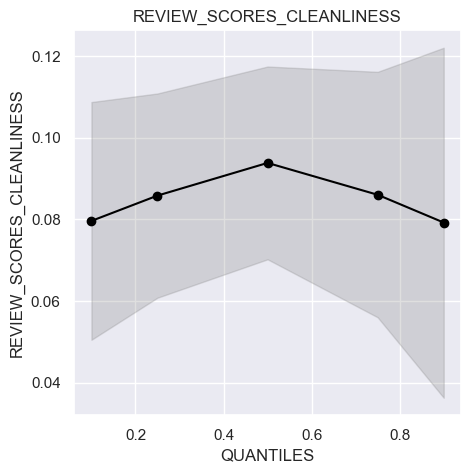

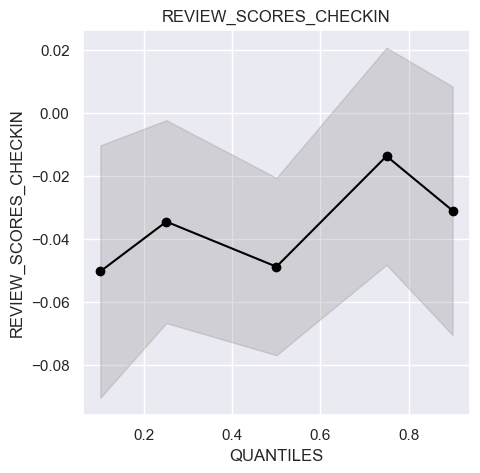

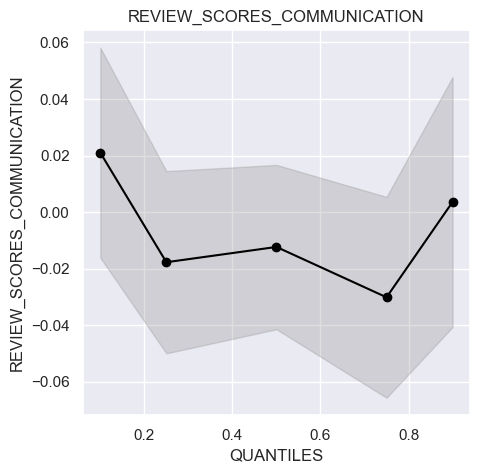

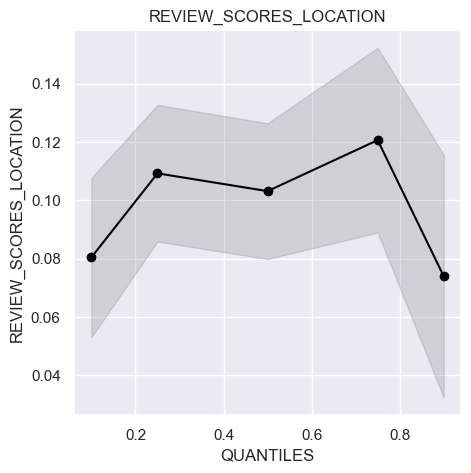

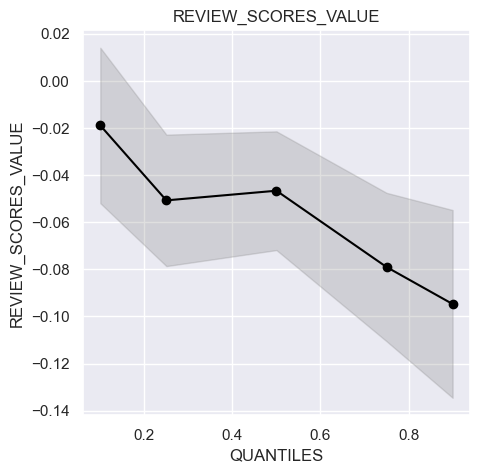

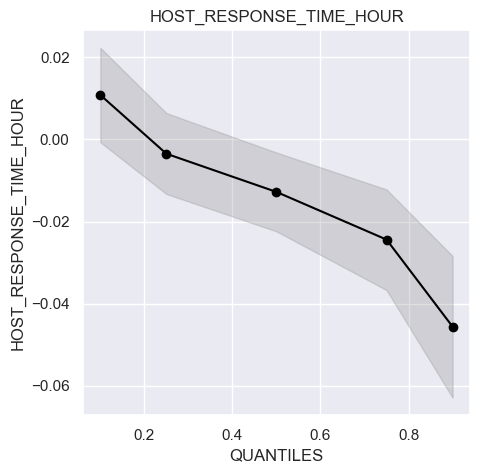

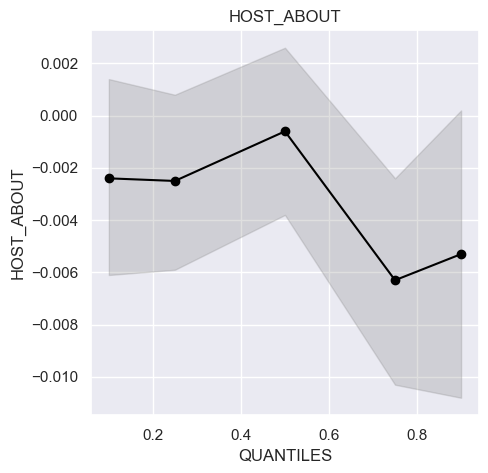

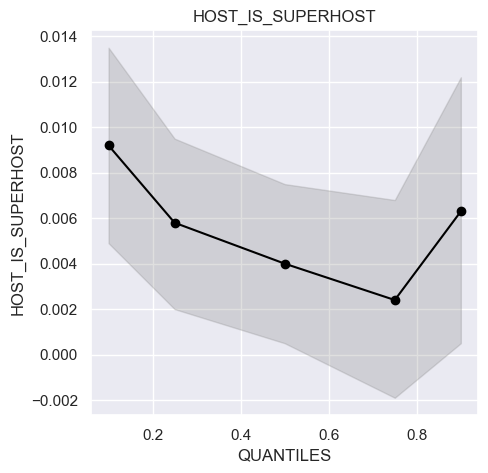

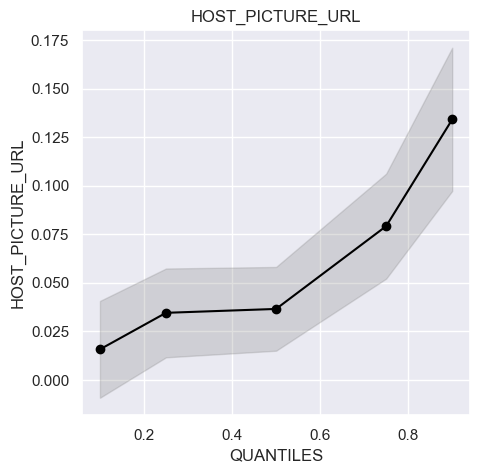

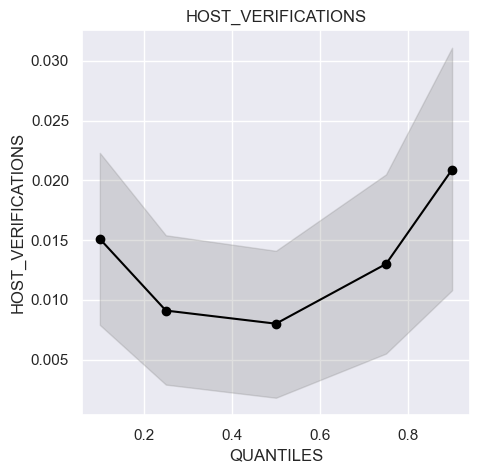

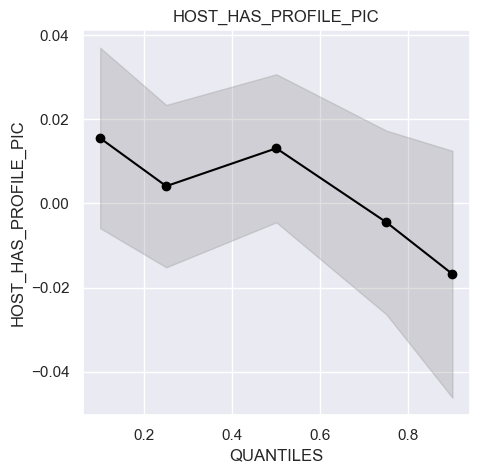

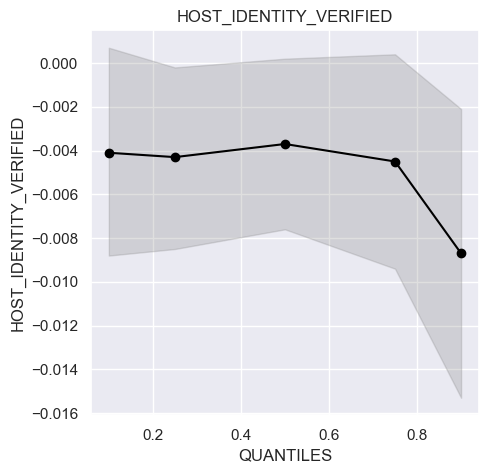

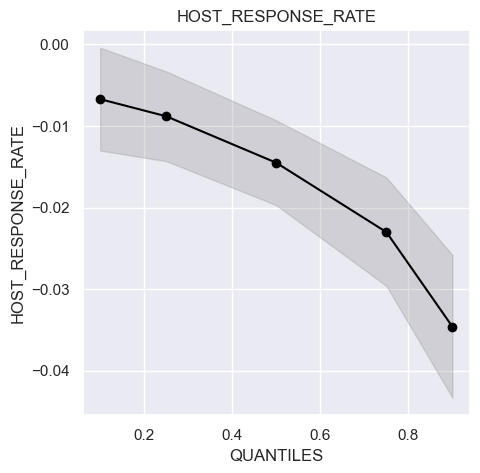

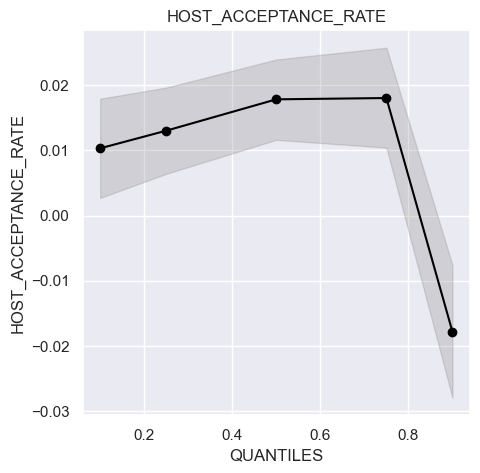

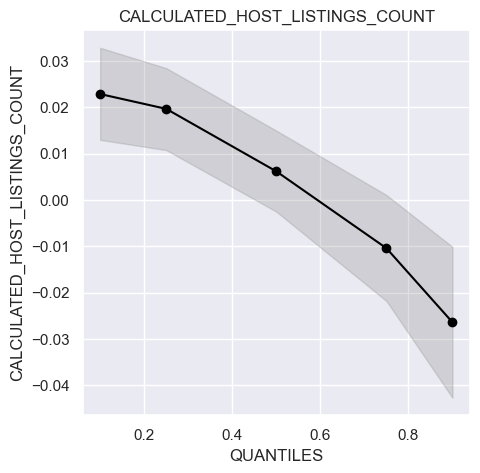

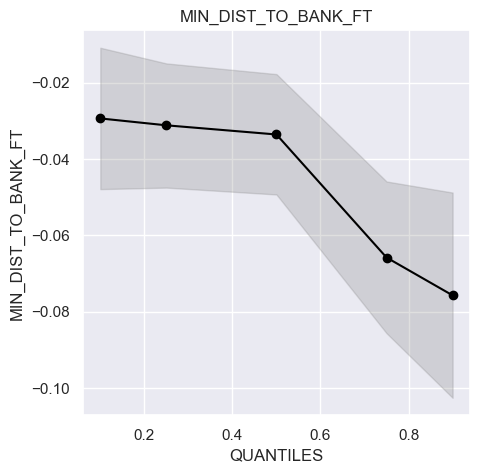

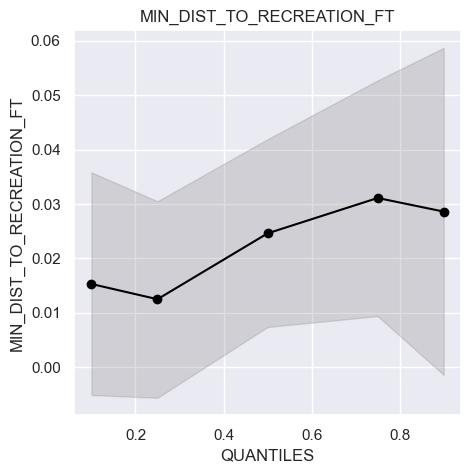

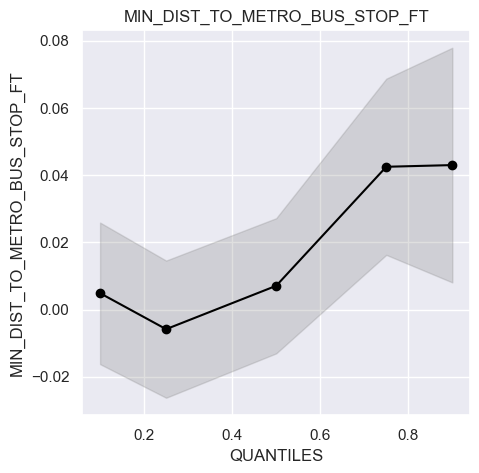

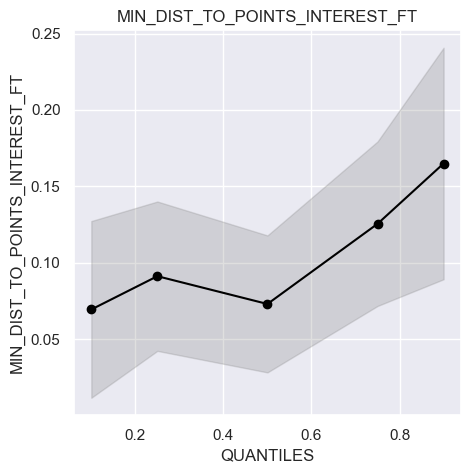

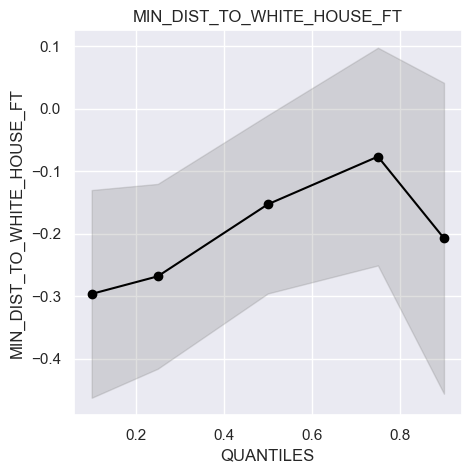

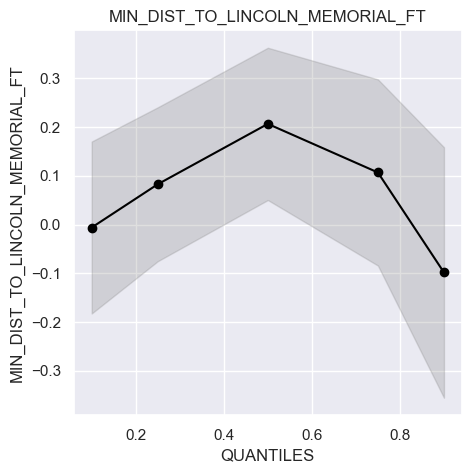

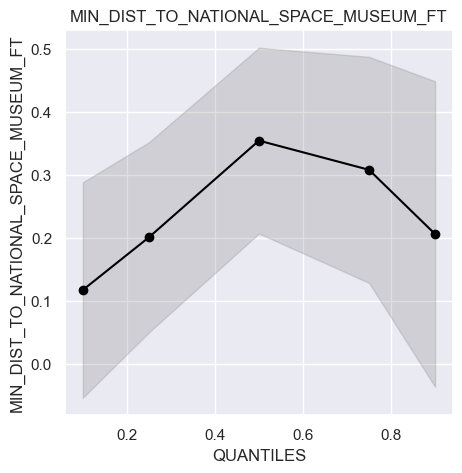

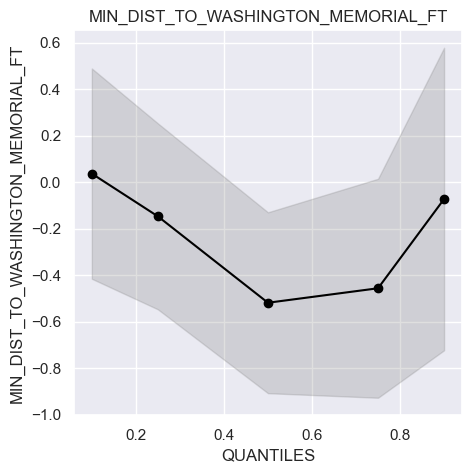

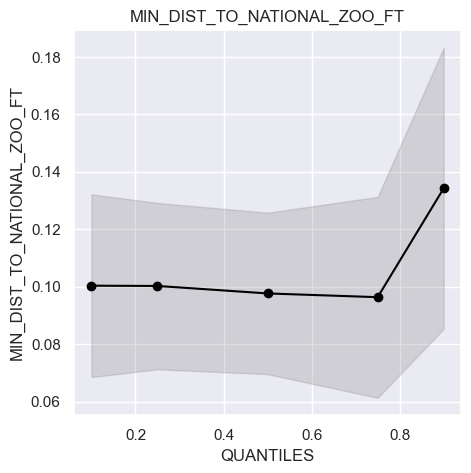

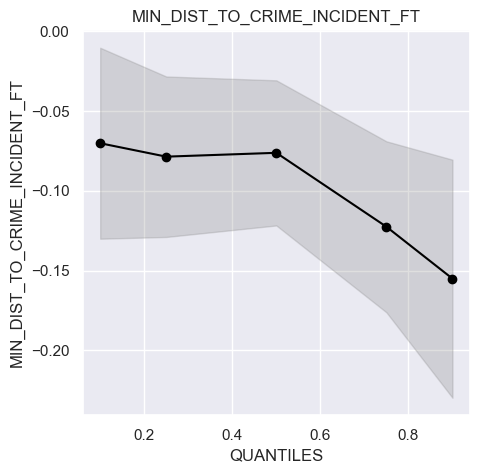

In [75]:
def graficar_resultado(p_caracteristica):
    NUEVO_DF = pd.DataFrame(columns=['q', 'intercept', 'coefb', 'lowerb', 'upperb'])
    NUEVO_DF.set_index("q", inplace=True)

    i = 1
    for q in quantiles:
        NUEVO_DF.loc[q, ["quantile_"]] = q
        NUEVO_DF.loc[q, ["coefb"]] = RESULTADOS.loc[p_caracteristica, ["coeficiente_"+str(q)]].values[0]
        NUEVO_DF.loc[q, ["intercept"]] = RESULTADOS.loc[p_caracteristica, ["intercept_"+str(q)]].values[0]
        NUEVO_DF.loc[q, ["lowerb"]] = RESULTADOS.loc[p_caracteristica, ["lower_"+str(q)]].values[0]
        NUEVO_DF.loc[q, ["upperb"]] = RESULTADOS.loc[p_caracteristica, ["upper_"+str(q)]].values[0]

    NUEVO_DF = NUEVO_DF.reset_index(drop=True)
    NUEVO_DF["coefb"] = NUEVO_DF["coefb"].astype(float)
    NUEVO_DF["intercept"] = NUEVO_DF["intercept"].astype(float)
    NUEVO_DF["lowerb"] = NUEVO_DF["lowerb"].astype(float)
    NUEVO_DF["upperb"] = NUEVO_DF["upperb"].astype(float)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(NUEVO_DF.quantile_, NUEVO_DF.coefb, color="black", label="Quantile Reg.", marker='o')
    ax.plot(NUEVO_DF.quantile_, NUEVO_DF.upperb, linestyle="none", color="black")
    ax.plot(NUEVO_DF.quantile_, NUEVO_DF.lowerb, linestyle="none", color="black") #dotted
    ax.fill_between(NUEVO_DF.quantile_, NUEVO_DF.upperb, NUEVO_DF.lowerb, color="gray", alpha=0.25)
    plt.ylabel(p_caracteristica.upper())
    plt.xlabel("QUANTILES")
    plt.title(p_caracteristica.upper())
    plt.show()
    i=i+1

for caracteristica in tmp_caracteristicas:
    if caracteristica != 'log_price':
        graficar_resultado(caracteristica)
        

Análisis de los modelos de regresión

In [76]:
RESULTADOS.head()

intercept_OLS  coeficiente_OLS  pvalue_OLS  lower_OLS  upper_OLS  coeficiente_0.1  intercept_0.1  lower_0.1  upper_0.1  pvalue_0.1  coeficiente_0.25  intercept_0.25  lower_0.25  upper_0.25  pvalue_0.25  coeficiente_0.5  intercept_0.5  lower_0.5  upper_0.5  pvalue_0.5  coeficiente_0.75  intercept_0.75  lower_0.75  upper_0.75  pvalue_0.75  coeficiente_0.9  intercept_0.9  lower_0.9  upper_0.9  pvalue_0.9
caracteristica                                                                                                                                                                                                                                                                                                                                                                                                                                            
min_dist_to_crime_incident_ft         -1.255302e+10          -0.1609      0.0000    -0.2153    -0.1064          -0.0702        -0.0172    -0.1300    -0.0104      0.0214           -0.0786         -0.0221     -0.1289     -0.0284       0.0022          -0.0762        -0.0023    -0.1217    -0.0308      0.0010           -0.1225          0.0452     -0.1761     -0.0690       0.0000          -0.1550         0.1514    -0.2296    -0.0805      0.0000
min_dist_to_national_zoo_ft           -1.255302e+10           0.1123      0.0000     0.0786     0.1459           0.1004        -0.0172     0.0686     0.1322      0.0000            0.1003         -0.0221      0.0713      0.1292       0.0000           0.0977        -0.0023     0.0696     0.1258      0.0000            0.0964          0.0452      0.0614      0.1313       0.0000           0.1343         0.1514     0.0854     0.1832      0.0000
min_dist_to_washington_memorial_ft    -1.255302e+10          -0.2055      0.3874    -0.6714     0.2605           0.0369        -0.0172    -0.4156     0.4893      0.8731           -0.1470         -0.0221     -0.5471      0.2532       0.4716          -0.5188        -0.0023    -0.9080    -0.1296      0.0090           -0.4565          0.0452     -0.9277      0.0147       0.0576          -0.0724         0.1514    -0.7233     0.5786      0.8275
min_dist_to_national_space_museum_ft  -1.255302e+10           0.2375      0.0083     0.0612     0.4138           0.1177        -0.0172    -0.0532     0.2885      0.1770            0.2012         -0.0221      0.0504      0.3520       0.0089           0.3546        -0.0023     0.2073     0.5019      0.0000            0.3083          0.0452      0.1290      0.4875       0.0008           0.2064         0.1514    -0.0359     0.4488      0.0950
min_dist_to_lincoln_memorial_ft       -1.255302e+10           0.0515      0.5892    -0.1355     0.2386          -0.0061        -0.0172    -0.1824     0.1703      0.9463            0.0827         -0.0221     -0.0752      0.2405       0.3046           0.2065        -0.0023     0.0503     0.3627      0.0096            0.1068          0.0452     -0.0841      0.2978       0.2728          -0.0983         0.1514    -0.3553     0.1586      0.4532

In [77]:
RESULTADOS[["coeficiente_OLS", "coeficiente_0.1","coeficiente_0.25","coeficiente_0.5","coeficiente_0.75","coeficiente_0.9","pvalue_OLS", "pvalue_0.1", "pvalue_0.25", "pvalue_0.5", "pvalue_0.75", "pvalue_0.9"]].head(100)

coeficiente_OLS  coeficiente_0.1  coeficiente_0.25  coeficiente_0.5  coeficiente_0.75  coeficiente_0.9  pvalue_OLS  pvalue_0.1  pvalue_0.25  pvalue_0.5  pvalue_0.75  pvalue_0.9
caracteristica                                                                                                                                                                                                        
min_dist_to_crime_incident_ft           -1.609000e-01          -0.0702           -0.0786          -0.0762           -0.1225          -0.1550      0.0000      0.0214       0.0022      0.0010       0.0000      0.0000
min_dist_to_national_zoo_ft              1.123000e-01           0.1004            0.1003           0.0977            0.0964           0.1343      0.0000      0.0000       0.0000      0.0000       0.0000      0.0000
min_dist_to_washington_memorial_ft      -2.055000e-01           0.0369           -0.1470          -0.5188           -0.4565          -0.0724      0.3874      0.8731       0.4716      0.0090       0.0576      0.8275
min_dist_to_national_space_museum_ft     2.375000e-01           0.1177            0.2012           0.3546            0.3083           0.2064      0.0083      0.1770       0.0089      0.0000       0.0008      0.0950
min_dist_to_lincoln_memorial_ft          5.150000e-02          -0.0061            0.0827           0.2065            0.1068          -0.0983      0.5892      0.9463       0.3046      0.0096       0.2728      0.4532
min_dist_to_white_house_ft              -2.333000e-01          -0.2965           -0.2684          -0.1532           -0.0769          -0.2075      0.0074      0.0005       0.0004      0.0352       0.3867      0.1019
min_dist_to_points_interest_ft           1.526000e-01           0.0693            0.0911           0.0729            0.1254           0.1649      0.0000      0.0188       0.0003      0.0014       0.0000      0.0000
min_dist_to_metro_bus_stop_ft            3.240000e-02           0.0049           -0.0058           0.0071            0.0425           0.0430      0.0084      0.6506       0.5789      0.4908       0.0015      0.0158
min_dist_to_recreation_ft                3.340000e-02           0.0153            0.0125           0.0246            0.0311           0.0286      0.0015      0.1417       0.1753      0.0051       0.0050      0.0616
min_dist_to_bank_ft                     -5.060000e-02          -0.0294           -0.0312          -0.0336           -0.0658          -0.0757      0.0000      0.0018       0.0002      0.0000       0.0000      0.0000
calculated_host_listings_count          -1.410000e-02           0.0229            0.0197           0.0062           -0.0104          -0.0264      0.0085      0.0000       0.0000      0.1631       0.0772      0.0015
host_acceptance_rate                     1.670000e-02           0.0103            0.0130           0.0178            0.0180          -0.0178      0.0000      0.0080       0.0001      0.0000       0.0000      0.0006
host_response_rate                      -2.070000e-02          -0.0067           -0.0088          -0.0145           -0.0230          -0.0346      0.0000      0.0368       0.0018      0.0000       0.0000      0.0000
host_identity_verified                  -7.400000e-03          -0.0041           -0.0043          -0.0037           -0.0045          -0.0087      0.0021      0.0914       0.0409      0.0658       0.0694      0.0095
host_has_profile_pic                     3.400000e-03           0.0155            0.0041           0.0131           -0.0045          -0.0168      0.7484      0.1563       0.6773      0.1454       0.6840      0.2603
host_verifications                       1.460000e-02           0.0151            0.0091           0.0080            0.0130           0.0209      0.0001      0.0000       0.0041      0.0107       0.0007      0.0001
host_picture_url                         5.050000e-02           0.0158            0.0346           0.0366            0.0792           0.1341      0.0001      0.2138    

In [78]:
#test = RESULTADOS.copy()
#test = test.reset_index(drop=False)
#test[test['caracteristica'] == 'property_type_pca'][['caracteristica', "coeficiente_OLS", "coeficiente_0.1","coeficiente_0.25","coeficiente_0.5","coeficiente_0.75","coeficiente_0.9", "pvalue_OLS", "pvalue_0.1", "pvalue_0.25", "pvalue_0.5", "pvalue_0.75", "pvalue_0.9"]].head()